In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import warnings
warnings.filterwarnings('ignore')
import tqdm

d:\repositories\Github-MachineLearning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure problem number here
PROBLEM_NUM = 36

X_path = f"./data_31_40/problem_{PROBLEM_NUM}/dataset_{PROBLEM_NUM}.csv"
y_path = f"./data_31_40/problem_{PROBLEM_NUM}/target_{PROBLEM_NUM}.csv"
Xeval_path = f"./data_31_40/problem_{PROBLEM_NUM}/EVAL_{PROBLEM_NUM}.csv"

X = pd.read_csv(X_path)
y = pd.read_csv(y_path)
X_eval = pd.read_csv(Xeval_path)

y1 = y["target01"]

print(f"Problem {PROBLEM_NUM}")
print(f"X: {X.shape}, y1: {y1.shape}, X_eval: {X_eval.shape}")
assert list(X.columns) == list(X_eval.columns), "Train/EVAL column mismatch!"

# Create train/validation split to detect overfitting
X_train, X_val, y_train, y_val = train_test_split(
    X, y1, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTrain/Val Split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Problem 36
X: (10000, 273), y1: (10000,), X_eval: (10000, 273)

Train/Val Split:
X_train: (8000, 273), y_train: (8000,)
X_val: (2000, 273), y_val: (2000,)


In [3]:
# Preprocessing pipeline
num_cols = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    ],
    remainder="drop"
)

# Fit and transform training data
X_train_processed = preprocess.fit_transform(X_train)
X_val_processed = preprocess.transform(X_val)

print(f"Preprocessed shapes: {X_train_processed.shape}, {X_val_processed.shape}")

Preprocessed shapes: (8000, 273), (2000, 273)


In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Optuna Hyperparameter Optimization with CatBoost

This implementation addresses overfitting by:
1. **Adding regularization parameters** (l2_leaf_reg, random_strength)
2. **Optimizing directly on validation R²** (not CV)
3. **Using early stopping** to prevent overtraining
4. **Constraining tree complexity** (depth, min_data_in_leaf)

CatBoost advantages:
- Built-in ordered boosting reduces overfitting
- Symmetric tree structure for better generalization
- Strong default regularization

In [5]:
def objective(trial):
    """
    Optuna objective function for CatBoost hyperparameter optimization.
    Optimizes on validation R² to prevent overfitting.
    """
    
    print(f"\n▶ Starting Trial {trial.number}...", flush=True)
    
    # Suggest hyperparameters with regularization focus
    params = {
        'iterations': trial.suggest_int('iterations', 300, 2000),  # Reduced from 5000 for speed
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Higher LR with fewer iterations
        'depth': trial.suggest_int('depth', 2, 10),  # CatBoost uses 'depth' not 'max_depth'
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        
        # KEY: L2 regularization to combat overfitting
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 100.0, log=True),
        
        # CatBoost-specific regularization
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        
        'random_state': 42,
        'verbose': 0,
        'thread_count': -1,
        'allow_writing_files': False  # Prevent CatBoost from writing files
    }
    
    print(f"  Training with {params['iterations']} iterations, LR={params['learning_rate']:.4f}...", flush=True)
    
    # Train model with early stopping
    model = CatBoostRegressor(**params)
    model.fit(
        X_train_processed, y_train,
        eval_set=(X_val_processed, y_val),
        early_stopping_rounds=30,  # More aggressive early stopping
        verbose=0,  # Changed from False to 0 for consistency
        plot=False
    )
    
    # Predict on validation set (detects overfitting)
    y_val_pred = model.predict(X_val_processed)
    val_rmse = rmse(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Also track training RMSE to monitor overfitting gap
    y_train_pred = model.predict(X_train_processed)
    train_rmse = rmse(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Store additional metrics for analysis
    trial.set_user_attr('train_rmse', train_rmse)
    trial.set_user_attr('val_rmse', val_rmse)
    trial.set_user_attr('train_r2', train_r2)
    trial.set_user_attr('val_r2', val_r2)
    trial.set_user_attr('overfitting_gap', val_rmse - train_rmse)
    trial.set_user_attr('r2_gap', train_r2 - val_r2)
    
    # Print trial results with R² information
    print(f"Trial {trial.number}: Val RMSE={val_rmse:.4f}, Val R²={val_r2:.4f} | Train RMSE={train_rmse:.4f}, Train R²={train_r2:.4f} | Gap={val_rmse - train_rmse:.4f}")
    sys.stdout.flush()  # Force output to display immediately
    
    return val_r2  # Maximize validation R²

In [6]:
# Create Optuna study
print("Starting Optuna Hyperparameter Optimization with CatBoost")
print("="*80)
print("Optimizing on validation R² (maximizing) to minimize overfitting...")
print()

study = optuna.create_study(
    direction='maximize',  # Maximize Val R²
    study_name='catboost_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization (adjust n_trials based on time/compute budget)
study.optimize(objective, n_trials=150, show_progress_bar=False)  # Disabled for better print visibility

print("\n" + "="*80)
print("Optimization Complete!")
print("="*80)

[I 2026-01-06 19:20:16,475] A new study created in memory with name: catboost_optimization


Starting Optuna Hyperparameter Optimization with CatBoost
Optimizing on validation R² (maximizing) to minimize overfitting...


▶ Starting Trial 0...
  Training with 937 iterations, LR=0.2537...
Trial 0: Val RMSE=0.2263, Val R²=0.0241 | Train RMSE=0.2122, Train R²=0.1366 | Gap=0.0140


[I 2026-01-06 19:20:18,911] Trial 0 finished with value: 0.0241496392468189 and parameters: {'iterations': 937, 'learning_rate': 0.2536999076681772, 'depth': 8, 'min_data_in_leaf': 60, 'subsample': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'l2_leaf_reg': 0.14936568554617632, 'random_strength': 5.3994844097874335, 'bagging_temperature': 6.011150117432088}. Best is trial 0 with value: 0.0241496392468189.



▶ Starting Trial 1...
  Training with 1504 iterations, LR=0.0107...
Trial 1: Val RMSE=0.1260, Val R²=0.6973 | Train RMSE=0.0251, Train R²=0.9879 | Gap=0.1009


[I 2026-01-06 19:24:18,283] Trial 1 finished with value: 0.6972563031950878 and parameters: {'iterations': 1504, 'learning_rate': 0.010725209743171996, 'depth': 10, 'min_data_in_leaf': 84, 'subsample': 0.6061695553391381, 'colsample_bylevel': 0.5909124836035503, 'l2_leaf_reg': 0.35498788321965025, 'random_strength': 0.4059611610484306, 'bagging_temperature': 5.247564316322379}. Best is trial 1 with value: 0.6972563031950878.



▶ Starting Trial 2...
  Training with 1034 iterations, LR=0.0269...
Trial 2: Val RMSE=0.1039, Val R²=0.7942 | Train RMSE=0.0492, Train R²=0.9536 | Gap=0.0547


[I 2026-01-06 19:24:50,740] Trial 2 finished with value: 0.7942108078492129 and parameters: {'iterations': 1034, 'learning_rate': 0.02692655251486473, 'depth': 7, 'min_data_in_leaf': 14, 'subsample': 0.6460723242676091, 'colsample_bylevel': 0.6831809216468459, 'l2_leaf_reg': 2.334586407601624, 'random_strength': 3.7183641805732095, 'bagging_temperature': 1.9967378215835974}. Best is trial 2 with value: 0.7942108078492129.



▶ Starting Trial 3...
  Training with 1174 iterations, LR=0.0750...
Trial 3: Val RMSE=0.2167, Val R²=0.1047 | Train RMSE=0.2088, Train R²=0.1642 | Gap=0.0079


[I 2026-01-06 19:24:51,687] Trial 3 finished with value: 0.10465666357847514 and parameters: {'iterations': 1174, 'learning_rate': 0.07500118950416987, 'depth': 2, 'min_data_in_leaf': 61, 'subsample': 0.5852620618436457, 'colsample_bylevel': 0.5325257964926398, 'l2_leaf_reg': 70.25166339242152, 'random_strength': 8.536189862866832, 'bagging_temperature': 8.08397348116461}. Best is trial 2 with value: 0.7942108078492129.



▶ Starting Trial 4...
  Training with 818 iterations, LR=0.0139...
Trial 4: Val RMSE=0.1997, Val R²=0.2397 | Train RMSE=0.1440, Train R²=0.6022 | Gap=0.0557


[I 2026-01-06 19:25:39,741] Trial 4 finished with value: 0.23966159930158626 and parameters: {'iterations': 818, 'learning_rate': 0.013940346079873234, 'depth': 8, 'min_data_in_leaf': 45, 'subsample': 0.5610191174223894, 'colsample_bylevel': 0.7475884550556351, 'l2_leaf_reg': 0.12681352169084595, 'random_strength': 6.586289317583113, 'bagging_temperature': 2.587799816000169}. Best is trial 2 with value: 0.7942108078492129.



▶ Starting Trial 5...
  Training with 1426 iterations, LR=0.0289...
Trial 5: Val RMSE=0.0964, Val R²=0.8229 | Train RMSE=0.0662, Train R²=0.9160 | Gap=0.0302


[I 2026-01-06 19:26:01,127] Trial 5 finished with value: 0.8228839879095318 and parameters: {'iterations': 1426, 'learning_rate': 0.028869220380495747, 'depth': 6, 'min_data_in_leaf': 55, 'subsample': 0.5924272277627636, 'colsample_bylevel': 0.9847923138822793, 'l2_leaf_reg': 21.154290797261208, 'random_strength': 7.56829206016762, 'bagging_temperature': 8.948273504276488}. Best is trial 5 with value: 0.8228839879095318.



▶ Starting Trial 6...
  Training with 1317 iterations, LR=0.2300...
Trial 6: Val RMSE=0.2152, Val R²=0.1174 | Train RMSE=0.2095, Train R²=0.1586 | Gap=0.0057


[I 2026-01-06 19:26:01,405] Trial 6 finished with value: 0.1174248659664483 and parameters: {'iterations': 1317, 'learning_rate': 0.22999586428143728, 'depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.522613644455269, 'colsample_bylevel': 0.6626651653816322, 'l2_leaf_reg': 1.4656553886225332, 'random_strength': 0.34889766548903667, 'bagging_temperature': 8.287375091519294}. Best is trial 5 with value: 0.8228839879095318.



▶ Starting Trial 7...
  Training with 906 iterations, LR=0.0260...
Trial 7: Val RMSE=0.1365, Val R²=0.6448 | Train RMSE=0.1156, Train R²=0.7437 | Gap=0.0209


[I 2026-01-06 19:26:14,899] Trial 7 finished with value: 0.6447944900373278 and parameters: {'iterations': 906, 'learning_rate': 0.026000059117302653, 'depth': 6, 'min_data_in_leaf': 15, 'subsample': 0.9010984903770198, 'colsample_bylevel': 0.5372753218398854, 'l2_leaf_reg': 91.33995846860967, 'random_strength': 3.5033984911586877, 'bagging_temperature': 1.987156815341724}. Best is trial 5 with value: 0.8228839879095318.



▶ Starting Trial 8...
  Training with 309 iterations, LR=0.1602...
Trial 8: Val RMSE=0.0921, Val R²=0.8382 | Train RMSE=0.0377, Train R²=0.9727 | Gap=0.0544


[I 2026-01-06 19:26:22,365] Trial 8 finished with value: 0.8381517730136578 and parameters: {'iterations': 309, 'learning_rate': 0.1601531217136121, 'depth': 8, 'min_data_in_leaf': 73, 'subsample': 0.8856351733429728, 'colsample_bylevel': 0.5370223258670452, 'l2_leaf_reg': 1.1895896737553546, 'random_strength': 0.17050539260269293, 'bagging_temperature': 8.631034258755935}. Best is trial 8 with value: 0.8381517730136578.



▶ Starting Trial 9...
  Training with 1360 iterations, LR=0.0308...
Trial 9: Val RMSE=0.2141, Val R²=0.1261 | Train RMSE=0.2070, Train R²=0.1788 | Gap=0.0072


[I 2026-01-06 19:26:24,349] Trial 9 finished with value: 0.12608518985112638 and parameters: {'iterations': 1360, 'learning_rate': 0.030816017044468066, 'depth': 2, 'min_data_in_leaf': 32, 'subsample': 0.6625916610133735, 'colsample_bylevel': 0.864803089169032, 'l2_leaf_reg': 8.178476574339538, 'random_strength': 5.948746813219773, 'bagging_temperature': 4.722149251619493}. Best is trial 8 with value: 0.8381517730136578.



▶ Starting Trial 10...
  Training with 334 iterations, LR=0.1104...
Trial 10: Val RMSE=0.0966, Val R²=0.8222 | Train RMSE=0.0084, Train R²=0.9986 | Gap=0.0882


[I 2026-01-06 19:27:20,102] Trial 10 finished with value: 0.8222350786019766 and parameters: {'iterations': 334, 'learning_rate': 0.11041930924484164, 'depth': 10, 'min_data_in_leaf': 94, 'subsample': 0.9896117410993797, 'colsample_bylevel': 0.8451235367845726, 'l2_leaf_reg': 0.5939923582689618, 'random_strength': 0.10525161528906533, 'bagging_temperature': 9.693130727540948}. Best is trial 8 with value: 0.8381517730136578.



▶ Starting Trial 11...
  Training with 1950 iterations, LR=0.1151...
Trial 11: Val RMSE=0.0957, Val R²=0.8254 | Train RMSE=0.0732, Train R²=0.8972 | Gap=0.0225


[I 2026-01-06 19:27:23,030] Trial 11 finished with value: 0.8253967155941742 and parameters: {'iterations': 1950, 'learning_rate': 0.11511579879447058, 'depth': 5, 'min_data_in_leaf': 74, 'subsample': 0.7848596544349612, 'colsample_bylevel': 0.9970029704981116, 'l2_leaf_reg': 11.90997542358353, 'random_strength': 1.4014640289440803, 'bagging_temperature': 9.980525992325887}. Best is trial 8 with value: 0.8381517730136578.



▶ Starting Trial 12...
  Training with 1895 iterations, LR=0.1365...
Trial 12: Val RMSE=0.0955, Val R²=0.8262 | Train RMSE=0.0742, Train R²=0.8945 | Gap=0.0213


[I 2026-01-06 19:27:25,284] Trial 12 finished with value: 0.8261668111977608 and parameters: {'iterations': 1895, 'learning_rate': 0.13645973655159005, 'depth': 4, 'min_data_in_leaf': 76, 'subsample': 0.8045369317168722, 'colsample_bylevel': 0.960200522923482, 'l2_leaf_reg': 7.637106304017789, 'random_strength': 1.5656255928895224, 'bagging_temperature': 7.386472109517053}. Best is trial 8 with value: 0.8381517730136578.



▶ Starting Trial 13...
  Training with 1994 iterations, LR=0.1783...
Trial 13: Val RMSE=0.0882, Val R²=0.8516 | Train RMSE=0.0727, Train R²=0.8985 | Gap=0.0155


[I 2026-01-06 19:27:26,655] Trial 13 finished with value: 0.8516040365167372 and parameters: {'iterations': 1994, 'learning_rate': 0.17828548077927453, 'depth': 4, 'min_data_in_leaf': 100, 'subsample': 0.8079213947096819, 'colsample_bylevel': 0.9007468277317288, 'l2_leaf_reg': 4.639548462267544, 'random_strength': 1.1683288886645202, 'bagging_temperature': 6.855046081289342}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 14...
  Training with 322 iterations, LR=0.1718...
Trial 14: Val RMSE=0.0929, Val R²=0.8355 | Train RMSE=0.0311, Train R²=0.9814 | Gap=0.0618


[I 2026-01-06 19:27:38,777] Trial 14 finished with value: 0.8354682393885482 and parameters: {'iterations': 322, 'learning_rate': 0.17184592058166204, 'depth': 8, 'min_data_in_leaf': 100, 'subsample': 0.8618649519902002, 'colsample_bylevel': 0.8758067124078944, 'l2_leaf_reg': 1.178677766857122, 'random_strength': 0.5887566238745403, 'bagging_temperature': 6.766327262559341}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 15...
  Training with 589 iterations, LR=0.0591...
Trial 15: Val RMSE=0.0926, Val R²=0.8366 | Train RMSE=0.0728, Train R²=0.8985 | Gap=0.0198


[I 2026-01-06 19:27:42,660] Trial 15 finished with value: 0.8365988743586175 and parameters: {'iterations': 589, 'learning_rate': 0.059077966101990294, 'depth': 4, 'min_data_in_leaf': 89, 'subsample': 0.724274028445038, 'colsample_bylevel': 0.7834418466621005, 'l2_leaf_reg': 4.109054680100627, 'random_strength': 0.10740407619157727, 'bagging_temperature': 3.8254914630948926}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 16...
  Training with 1727 iterations, LR=0.0880...
Trial 16: Val RMSE=0.1108, Val R²=0.7658 | Train RMSE=0.0928, Train R²=0.8349 | Gap=0.0181


[I 2026-01-06 19:27:44,407] Trial 16 finished with value: 0.7657622756953966 and parameters: {'iterations': 1727, 'learning_rate': 0.08801819602632835, 'depth': 4, 'min_data_in_leaf': 70, 'subsample': 0.9202685958641559, 'colsample_bylevel': 0.6864702896800229, 'l2_leaf_reg': 0.627005019396682, 'random_strength': 0.25488827377413215, 'bagging_temperature': 0.13179214380923554}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 17...
  Training with 662 iterations, LR=0.2849...
Trial 17: Val RMSE=0.1068, Val R²=0.7824 | Train RMSE=0.0273, Train R²=0.9857 | Gap=0.0795


[I 2026-01-06 19:28:18,612] Trial 17 finished with value: 0.782372113212296 and parameters: {'iterations': 662, 'learning_rate': 0.2848526822596654, 'depth': 9, 'min_data_in_leaf': 84, 'subsample': 0.8382336425816156, 'colsample_bylevel': 0.915669933962951, 'l2_leaf_reg': 29.301976669945155, 'random_strength': 1.9513394048259691, 'bagging_temperature': 6.71236967350552}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 18...
  Training with 583 iterations, LR=0.1498...
Trial 18: Val RMSE=0.0909, Val R²=0.8426 | Train RMSE=0.0645, Train R²=0.9203 | Gap=0.0264


[I 2026-01-06 19:28:21,286] Trial 18 finished with value: 0.8426296871211525 and parameters: {'iterations': 583, 'learning_rate': 0.14982807062764933, 'depth': 5, 'min_data_in_leaf': 2, 'subsample': 0.7307588793548139, 'colsample_bylevel': 0.7915334706194277, 'l2_leaf_reg': 2.6634210137722167, 'random_strength': 0.7697866328871257, 'bagging_temperature': 7.859556137864409}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 19...
  Training with 1644 iterations, LR=0.0430...
Trial 19: Val RMSE=0.1363, Val R²=0.6458 | Train RMSE=0.1253, Train R²=0.6988 | Gap=0.0110


[I 2026-01-06 19:28:23,491] Trial 19 finished with value: 0.6457899918749355 and parameters: {'iterations': 1644, 'learning_rate': 0.04302553031342478, 'depth': 3, 'min_data_in_leaf': 5, 'subsample': 0.7334769631983122, 'colsample_bylevel': 0.7975079435503242, 'l2_leaf_reg': 3.893210930114769, 'random_strength': 0.8078320352814228, 'bagging_temperature': 7.267795675592327}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 20...
  Training with 532 iterations, LR=0.1781...
Trial 20: Val RMSE=0.0944, Val R²=0.8302 | Train RMSE=0.0668, Train R²=0.9144 | Gap=0.0276


[I 2026-01-06 19:28:25,765] Trial 20 finished with value: 0.8301720398091266 and parameters: {'iterations': 532, 'learning_rate': 0.17808801137785688, 'depth': 5, 'min_data_in_leaf': 40, 'subsample': 0.7020843771180812, 'colsample_bylevel': 0.9192935333529578, 'l2_leaf_reg': 2.701107345170685, 'random_strength': 0.7924463049722684, 'bagging_temperature': 5.644150182251753}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 21...
  Training with 492 iterations, LR=0.1687...
Trial 21: Val RMSE=0.0926, Val R²=0.8367 | Train RMSE=0.0595, Train R²=0.9322 | Gap=0.0331


[I 2026-01-06 19:28:28,576] Trial 21 finished with value: 0.8367107878689004 and parameters: {'iterations': 492, 'learning_rate': 0.16873499389944926, 'depth': 5, 'min_data_in_leaf': 28, 'subsample': 0.7747921843260647, 'colsample_bylevel': 0.7391004139841214, 'l2_leaf_reg': 1.1636880438193602, 'random_strength': 0.20045010179172404, 'bagging_temperature': 8.786270065830331}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 22...
  Training with 406 iterations, LR=0.0928...
Trial 22: Val RMSE=0.0890, Val R²=0.8490 | Train RMSE=0.0396, Train R²=0.9700 | Gap=0.0494


[I 2026-01-06 19:28:42,444] Trial 22 finished with value: 0.8490402557554111 and parameters: {'iterations': 406, 'learning_rate': 0.09279240763079744, 'depth': 7, 'min_data_in_leaf': 100, 'subsample': 0.9635596103710082, 'colsample_bylevel': 0.8158215197569956, 'l2_leaf_reg': 4.857577198270003, 'random_strength': 2.3980345904032716, 'bagging_temperature': 7.838400821893334}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 23...
  Training with 778 iterations, LR=0.0883...
Trial 23: Val RMSE=0.0922, Val R²=0.8380 | Train RMSE=0.0455, Train R²=0.9604 | Gap=0.0467


[I 2026-01-06 19:28:55,317] Trial 23 finished with value: 0.8379681477621287 and parameters: {'iterations': 778, 'learning_rate': 0.08833659891403706, 'depth': 7, 'min_data_in_leaf': 100, 'subsample': 0.9736360308033737, 'colsample_bylevel': 0.8188476110146798, 'l2_leaf_reg': 6.763123303373585, 'random_strength': 2.636923766174481, 'bagging_temperature': 7.510882509824127}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 24...
  Training with 1147 iterations, LR=0.0606...
Trial 24: Val RMSE=0.1089, Val R²=0.7738 | Train RMSE=0.0977, Train R²=0.8170 | Gap=0.0112


[I 2026-01-06 19:28:57,745] Trial 24 finished with value: 0.7737696434691184 and parameters: {'iterations': 1147, 'learning_rate': 0.06063132183142608, 'depth': 3, 'min_data_in_leaf': 91, 'subsample': 0.8311673799312548, 'colsample_bylevel': 0.9295400141254617, 'l2_leaf_reg': 16.86682443658865, 'random_strength': 1.3284861693898808, 'bagging_temperature': 6.348544087130612}. Best is trial 13 with value: 0.8516040365167372.



▶ Starting Trial 25...
  Training with 640 iterations, LR=0.1105...
Trial 25: Val RMSE=0.0854, Val R²=0.8611 | Train RMSE=0.0423, Train R²=0.9658 | Gap=0.0431


[I 2026-01-06 19:29:08,112] Trial 25 finished with value: 0.8610890759759997 and parameters: {'iterations': 640, 'learning_rate': 0.11047072253655552, 'depth': 7, 'min_data_in_leaf': 80, 'subsample': 0.9431361129264633, 'colsample_bylevel': 0.8928101324380944, 'l2_leaf_reg': 4.076753245815513, 'random_strength': 1.0397891502683467, 'bagging_temperature': 4.8374541228636865}. Best is trial 25 with value: 0.8610890759759997.



▶ Starting Trial 26...
  Training with 431 iterations, LR=0.0435...
Trial 26: Val RMSE=0.0938, Val R²=0.8323 | Train RMSE=0.0597, Train R²=0.9316 | Gap=0.0341


[I 2026-01-06 19:29:23,944] Trial 26 finished with value: 0.8323477440090268 and parameters: {'iterations': 431, 'learning_rate': 0.04349648730668664, 'depth': 7, 'min_data_in_leaf': 82, 'subsample': 0.943093613913292, 'colsample_bylevel': 0.8847596192316918, 'l2_leaf_reg': 4.230445467540002, 'random_strength': 2.201920366631124, 'bagging_temperature': 4.3257281496429405}. Best is trial 25 with value: 0.8610890759759997.



▶ Starting Trial 27...
  Training with 706 iterations, LR=0.1022...
Trial 27: Val RMSE=0.0827, Val R²=0.8697 | Train RMSE=0.0445, Train R²=0.9620 | Gap=0.0382


[I 2026-01-06 19:29:32,494] Trial 27 finished with value: 0.8697175965065044 and parameters: {'iterations': 706, 'learning_rate': 0.1022268832486803, 'depth': 6, 'min_data_in_leaf': 96, 'subsample': 0.9517727397198947, 'colsample_bylevel': 0.8371038489150053, 'l2_leaf_reg': 5.949978651136336, 'random_strength': 1.1408587999040412, 'bagging_temperature': 3.5001060662528616}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 28...
  Training with 743 iterations, LR=0.1295...
Trial 28: Val RMSE=0.0842, Val R²=0.8649 | Train RMSE=0.0550, Train R²=0.9419 | Gap=0.0291


[I 2026-01-06 19:29:38,495] Trial 28 finished with value: 0.8649071756737075 and parameters: {'iterations': 743, 'learning_rate': 0.12953914378624054, 'depth': 6, 'min_data_in_leaf': 93, 'subsample': 0.9295312559848903, 'colsample_bylevel': 0.9417384044065469, 'l2_leaf_reg': 12.642478217891824, 'random_strength': 1.1346240905440064, 'bagging_temperature': 3.46141877515398}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 29...
  Training with 735 iterations, LR=0.2184...
Trial 29: Val RMSE=0.1231, Val R²=0.7111 | Train RMSE=0.0980, Train R²=0.8157 | Gap=0.0251


[I 2026-01-06 19:29:41,517] Trial 29 finished with value: 0.7111137492931434 and parameters: {'iterations': 735, 'learning_rate': 0.2184332558959745, 'depth': 6, 'min_data_in_leaf': 69, 'subsample': 0.9326485472247757, 'colsample_bylevel': 0.9566285563055782, 'l2_leaf_reg': 46.71639617745464, 'random_strength': 0.48174239293001797, 'bagging_temperature': 3.3363821711060155}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 30...
  Training with 926 iterations, LR=0.1173...
Trial 30: Val RMSE=0.1252, Val R²=0.7012 | Train RMSE=0.0551, Train R²=0.9417 | Gap=0.0701


[I 2026-01-06 19:30:22,004] Trial 30 finished with value: 0.7011793902089418 and parameters: {'iterations': 926, 'learning_rate': 0.11729516778287122, 'depth': 9, 'min_data_in_leaf': 62, 'subsample': 0.8861899021163041, 'colsample_bylevel': 0.8371086675678869, 'l2_leaf_reg': 15.35748392255351, 'random_strength': 0.9797272169488472, 'bagging_temperature': 0.5382368877388588}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 31...
  Training with 1090 iterations, LR=0.2222...
Trial 31: Val RMSE=0.1019, Val R²=0.8022 | Train RMSE=0.0779, Train R²=0.8836 | Gap=0.0240


[I 2026-01-06 19:30:25,541] Trial 31 finished with value: 0.8021701249249792 and parameters: {'iterations': 1090, 'learning_rate': 0.22218057695474544, 'depth': 6, 'min_data_in_leaf': 93, 'subsample': 0.9902032621618898, 'colsample_bylevel': 0.8902621782470905, 'l2_leaf_reg': 11.713706170234842, 'random_strength': 0.9413660385328564, 'bagging_temperature': 3.315172807044731}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 32...
  Training with 682 iterations, LR=0.0730...
Trial 32: Val RMSE=0.0913, Val R²=0.8411 | Train RMSE=0.0673, Train R²=0.9131 | Gap=0.0240


[I 2026-01-06 19:30:37,743] Trial 32 finished with value: 0.8411027612867314 and parameters: {'iterations': 682, 'learning_rate': 0.07300572686481753, 'depth': 6, 'min_data_in_leaf': 80, 'subsample': 0.9465812926291134, 'colsample_bylevel': 0.9401745412392493, 'l2_leaf_reg': 30.95339236530681, 'random_strength': 1.2657851710340384, 'bagging_temperature': 5.28800361828967}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 33...
  Training with 857 iterations, LR=0.1304...
Trial 33: Val RMSE=0.0935, Val R²=0.8333 | Train RMSE=0.0550, Train R²=0.9421 | Gap=0.0385


[I 2026-01-06 19:30:46,205] Trial 33 finished with value: 0.8333320573553735 and parameters: {'iterations': 857, 'learning_rate': 0.13044351632394646, 'depth': 7, 'min_data_in_leaf': 88, 'subsample': 0.9120896194074302, 'colsample_bylevel': 0.9015312868560607, 'l2_leaf_reg': 5.914389277193217, 'random_strength': 0.6331003847519748, 'bagging_temperature': 4.434242107443339}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 34...
  Training with 987 iterations, LR=0.1027...
Trial 34: Val RMSE=0.1120, Val R²=0.7608 | Train RMSE=0.0939, Train R²=0.8309 | Gap=0.0181


[I 2026-01-06 19:30:48,223] Trial 34 finished with value: 0.7608372993138455 and parameters: {'iterations': 987, 'learning_rate': 0.10272547482640268, 'depth': 3, 'min_data_in_leaf': 95, 'subsample': 0.8468167864858824, 'colsample_bylevel': 0.861104447722061, 'l2_leaf_reg': 2.0780102935698483, 'random_strength': 3.4394908661648325, 'bagging_temperature': 2.2558202631113966}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 35...
  Training with 693 iterations, LR=0.0724...
Trial 35: Val RMSE=0.0952, Val R²=0.8273 | Train RMSE=0.0738, Train R²=0.8955 | Gap=0.0213


[I 2026-01-06 19:30:52,949] Trial 35 finished with value: 0.8273023805790714 and parameters: {'iterations': 693, 'learning_rate': 0.07236397068299515, 'depth': 5, 'min_data_in_leaf': 86, 'subsample': 0.8704699528998835, 'colsample_bylevel': 0.9694696599366144, 'l2_leaf_reg': 9.959293624702157, 'random_strength': 1.1349093147318503, 'bagging_temperature': 3.8820793912377933}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 36...
  Training with 1581 iterations, LR=0.2748...
Trial 36: Val RMSE=0.1098, Val R²=0.7701 | Train RMSE=0.0469, Train R²=0.9579 | Gap=0.0630


[I 2026-01-06 19:30:58,500] Trial 36 finished with value: 0.7701472157347229 and parameters: {'iterations': 1581, 'learning_rate': 0.2747636513784314, 'depth': 7, 'min_data_in_leaf': 96, 'subsample': 0.8111691627386142, 'colsample_bylevel': 0.9065436059817457, 'l2_leaf_reg': 1.787618924006569, 'random_strength': 1.5860243008395438, 'bagging_temperature': 2.8724585847334994}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 37...
  Training with 1232 iterations, LR=0.2072...
Trial 37: Val RMSE=0.1111, Val R²=0.7646 | Train RMSE=0.0215, Train R²=0.9911 | Gap=0.0896


[I 2026-01-06 19:31:20,271] Trial 37 finished with value: 0.7645858192398856 and parameters: {'iterations': 1232, 'learning_rate': 0.20723038609529687, 'depth': 9, 'min_data_in_leaf': 64, 'subsample': 0.995606196763212, 'colsample_bylevel': 0.9398181243841324, 'l2_leaf_reg': 0.20878124164736048, 'random_strength': 0.41911473865611504, 'bagging_temperature': 1.442692508181607}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 38...
  Training with 801 iterations, LR=0.1324...
Trial 38: Val RMSE=0.1375, Val R²=0.6398 | Train RMSE=0.0937, Train R²=0.8317 | Gap=0.0437


[I 2026-01-06 19:31:31,030] Trial 38 finished with value: 0.6398390543905292 and parameters: {'iterations': 801, 'learning_rate': 0.13235173854679905, 'depth': 8, 'min_data_in_leaf': 80, 'subsample': 0.9620411161968845, 'colsample_bylevel': 0.7615288084990589, 'l2_leaf_reg': 22.229549344873135, 'random_strength': 1.7937514200489595, 'bagging_temperature': 5.1920584818795135}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 39...
  Training with 626 iterations, LR=0.0467...
Trial 39: Val RMSE=0.1010, Val R²=0.8057 | Train RMSE=0.0806, Train R²=0.8756 | Gap=0.0204


[I 2026-01-06 19:31:35,791] Trial 39 finished with value: 0.8056622014205654 and parameters: {'iterations': 626, 'learning_rate': 0.04669762779146217, 'depth': 4, 'min_data_in_leaf': 48, 'subsample': 0.9114635760018817, 'colsample_bylevel': 0.8455281728179848, 'l2_leaf_reg': 3.0452973874278557, 'random_strength': 4.2258198690476325, 'bagging_temperature': 5.557471959467854}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 40...
  Training with 977 iterations, LR=0.0188...
Trial 40: Val RMSE=0.0948, Val R²=0.8287 | Train RMSE=0.0666, Train R²=0.9149 | Gap=0.0282


[I 2026-01-06 19:31:53,413] Trial 40 finished with value: 0.8286679770001398 and parameters: {'iterations': 977, 'learning_rate': 0.018755037802199732, 'depth': 6, 'min_data_in_leaf': 87, 'subsample': 0.6471147687908045, 'colsample_bylevel': 0.7175091218326058, 'l2_leaf_reg': 0.7138531674015146, 'random_strength': 0.569847887026586, 'bagging_temperature': 3.987207511515389}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 41...
  Training with 421 iterations, LR=0.0919...
Trial 41: Val RMSE=0.0968, Val R²=0.8213 | Train RMSE=0.0418, Train R²=0.9665 | Gap=0.0550


[I 2026-01-06 19:32:06,992] Trial 41 finished with value: 0.8213375919766427 and parameters: {'iterations': 421, 'learning_rate': 0.09191376563676185, 'depth': 7, 'min_data_in_leaf': 100, 'subsample': 0.9589630457874957, 'colsample_bylevel': 0.817093861715638, 'l2_leaf_reg': 4.77901533846817, 'random_strength': 2.679042940150813, 'bagging_temperature': 6.071666417332284}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 42...
  Training with 443 iterations, LR=0.0971...
Trial 42: Val RMSE=0.0833, Val R²=0.8677 | Train RMSE=0.0395, Train R²=0.9701 | Gap=0.0438


[I 2026-01-06 19:32:19,025] Trial 42 finished with value: 0.867688314690902 and parameters: {'iterations': 443, 'learning_rate': 0.09706795141101436, 'depth': 7, 'min_data_in_leaf': 96, 'subsample': 0.9310490793548468, 'colsample_bylevel': 0.8338699129075691, 'l2_leaf_reg': 5.7409516828903415, 'random_strength': 2.3040100487927315, 'bagging_temperature': 4.872814163785874}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 43...
  Training with 517 iterations, LR=0.0773...
Trial 43: Val RMSE=0.0952, Val R²=0.8271 | Train RMSE=0.0413, Train R²=0.9674 | Gap=0.0540


[I 2026-01-06 19:32:40,374] Trial 43 finished with value: 0.8270969399558303 and parameters: {'iterations': 517, 'learning_rate': 0.07730827167781065, 'depth': 8, 'min_data_in_leaf': 92, 'subsample': 0.8908057522930595, 'colsample_bylevel': 0.5957202956591534, 'l2_leaf_reg': 7.442997521191849, 'random_strength': 1.098952454432967, 'bagging_temperature': 4.6300531004404615}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 44...
  Training with 846 iterations, LR=0.1978...
Trial 44: Val RMSE=0.1016, Val R²=0.8031 | Train RMSE=0.0455, Train R²=0.9603 | Gap=0.0561


[I 2026-01-06 19:32:48,397] Trial 44 finished with value: 0.8031417504922556 and parameters: {'iterations': 846, 'learning_rate': 0.19780995116497904, 'depth': 7, 'min_data_in_leaf': 77, 'subsample': 0.9299576942305057, 'colsample_bylevel': 0.9801650605308446, 'l2_leaf_reg': 10.131770220392234, 'random_strength': 1.867163574968869, 'bagging_temperature': 4.855538105261427}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 45...
  Training with 1446 iterations, LR=0.1430...
Trial 45: Val RMSE=0.0870, Val R²=0.8556 | Train RMSE=0.0509, Train R²=0.9503 | Gap=0.0361


[I 2026-01-06 19:32:54,855] Trial 45 finished with value: 0.8556431776691763 and parameters: {'iterations': 1446, 'learning_rate': 0.14299005305854837, 'depth': 6, 'min_data_in_leaf': 96, 'subsample': 0.8609882313192453, 'colsample_bylevel': 0.8563938070145529, 'l2_leaf_reg': 14.526866924780844, 'random_strength': 4.106096683819013, 'bagging_temperature': 2.9528912300447634}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 46...
  Training with 1233 iterations, LR=0.1097...
Trial 46: Val RMSE=0.0964, Val R²=0.8230 | Train RMSE=0.0568, Train R²=0.9382 | Gap=0.0396


[I 2026-01-06 19:33:05,663] Trial 46 finished with value: 0.8229681903887252 and parameters: {'iterations': 1233, 'learning_rate': 0.10971456043614548, 'depth': 6, 'min_data_in_leaf': 55, 'subsample': 0.8731138934916813, 'colsample_bylevel': 0.8536138410693428, 'l2_leaf_reg': 47.079031030172, 'random_strength': 7.345162388216203, 'bagging_temperature': 1.620260995010141}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 47...
  Training with 1355 iterations, LR=0.1375...
Trial 47: Val RMSE=0.0931, Val R²=0.8348 | Train RMSE=0.0465, Train R²=0.9586 | Gap=0.0466


[I 2026-01-06 19:33:14,219] Trial 47 finished with value: 0.8347852414973028 and parameters: {'iterations': 1355, 'learning_rate': 0.13746742522706773, 'depth': 6, 'min_data_in_leaf': 96, 'subsample': 0.9021475806552299, 'colsample_bylevel': 0.876536412944446, 'l2_leaf_reg': 14.619411937038901, 'random_strength': 4.825342482543684, 'bagging_temperature': 3.1629817401700757}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 48...
  Training with 1050 iterations, LR=0.0635...
Trial 48: Val RMSE=0.0913, Val R²=0.8412 | Train RMSE=0.0656, Train R²=0.9174 | Gap=0.0257


[I 2026-01-06 19:33:22,674] Trial 48 finished with value: 0.8411687949510073 and parameters: {'iterations': 1050, 'learning_rate': 0.06348772691530476, 'depth': 5, 'min_data_in_leaf': 90, 'subsample': 0.9776997142058074, 'colsample_bylevel': 0.8325927440417983, 'l2_leaf_reg': 21.457181384903503, 'random_strength': 9.01152845350132, 'bagging_temperature': 2.3299335141314925}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 49...
  Training with 1438 iterations, LR=0.1185...
Trial 49: Val RMSE=0.0953, Val R²=0.8270 | Train RMSE=0.0538, Train R²=0.9444 | Gap=0.0414


[I 2026-01-06 19:33:30,302] Trial 49 finished with value: 0.826994982546801 and parameters: {'iterations': 1438, 'learning_rate': 0.11847855523266479, 'depth': 6, 'min_data_in_leaf': 84, 'subsample': 0.9385518298613834, 'colsample_bylevel': 0.7709917278645344, 'l2_leaf_reg': 8.76998292966208, 'random_strength': 3.176642391927455, 'bagging_temperature': 3.675961838062895}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 50...
  Training with 570 iterations, LR=0.1510...
Trial 50: Val RMSE=0.1021, Val R²=0.8011 | Train RMSE=0.0227, Train R²=0.9902 | Gap=0.0795


[I 2026-01-06 19:33:59,352] Trial 50 finished with value: 0.8010976272585878 and parameters: {'iterations': 570, 'learning_rate': 0.1509854420859981, 'depth': 8, 'min_data_in_leaf': 66, 'subsample': 0.5401544309375504, 'colsample_bylevel': 0.8652244367549388, 'l2_leaf_reg': 6.089160064985724, 'random_strength': 5.718340277630461, 'bagging_temperature': 2.655535550100978}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 51...
  Training with 743 iterations, LR=0.1882...
Trial 51: Val RMSE=0.1041, Val R²=0.7935 | Train RMSE=0.0582, Train R²=0.9350 | Gap=0.0458


[I 2026-01-06 19:34:06,305] Trial 51 finished with value: 0.7935073790784949 and parameters: {'iterations': 743, 'learning_rate': 0.18821679576755856, 'depth': 7, 'min_data_in_leaf': 96, 'subsample': 0.8164609009499474, 'colsample_bylevel': 0.8962138293692217, 'l2_leaf_reg': 5.32286526925745, 'random_strength': 1.4973733125145212, 'bagging_temperature': 2.964772809074849}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 52...
  Training with 1809 iterations, LR=0.1535...
Trial 52: Val RMSE=0.0827, Val R²=0.8697 | Train RMSE=0.0556, Train R²=0.9407 | Gap=0.0271


[I 2026-01-06 19:34:10,716] Trial 52 finished with value: 0.8696879573487253 and parameters: {'iterations': 1809, 'learning_rate': 0.15346169857701156, 'depth': 5, 'min_data_in_leaf': 96, 'subsample': 0.85648282198056, 'colsample_bylevel': 0.951910075182521, 'l2_leaf_reg': 3.549034881256632, 'random_strength': 0.6896734566863697, 'bagging_temperature': 4.305808730605516}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 53...
  Training with 1739 iterations, LR=0.0975...
Trial 53: Val RMSE=0.0878, Val R²=0.8532 | Train RMSE=0.0616, Train R²=0.9272 | Gap=0.0262


[I 2026-01-06 19:34:16,978] Trial 53 finished with value: 0.8532006673281658 and parameters: {'iterations': 1739, 'learning_rate': 0.09748789244112915, 'depth': 5, 'min_data_in_leaf': 92, 'subsample': 0.8578886255431138, 'colsample_bylevel': 0.9382297250883299, 'l2_leaf_reg': 3.2777314481793294, 'random_strength': 0.3249161325849793, 'bagging_temperature': 4.132803706474883}. Best is trial 27 with value: 0.8697175965065044.



▶ Starting Trial 54...
  Training with 1541 iterations, LR=0.0810...
Trial 54: Val RMSE=0.0815, Val R²=0.8734 | Train RMSE=0.0471, Train R²=0.9575 | Gap=0.0344


[I 2026-01-06 19:34:26,563] Trial 54 finished with value: 0.8733698596951007 and parameters: {'iterations': 1541, 'learning_rate': 0.08098626499885951, 'depth': 6, 'min_data_in_leaf': 78, 'subsample': 0.7805704511465267, 'colsample_bylevel': 0.9994368317720322, 'l2_leaf_reg': 1.8450771498045158, 'random_strength': 0.6370674933233148, 'bagging_temperature': 3.552443609921986}. Best is trial 54 with value: 0.8733698596951007.



▶ Starting Trial 55...
  Training with 1598 iterations, LR=0.1221...
Trial 55: Val RMSE=0.0847, Val R²=0.8634 | Train RMSE=0.0575, Train R²=0.9365 | Gap=0.0271


[I 2026-01-06 19:34:31,173] Trial 55 finished with value: 0.8633759839243018 and parameters: {'iterations': 1598, 'learning_rate': 0.12207072540125499, 'depth': 5, 'min_data_in_leaf': 77, 'subsample': 0.7826870640252976, 'colsample_bylevel': 0.9982521608821866, 'l2_leaf_reg': 1.9010194846982789, 'random_strength': 0.6814422190093194, 'bagging_temperature': 3.6724742032063493}. Best is trial 54 with value: 0.8733698596951007.



▶ Starting Trial 56...
  Training with 1843 iterations, LR=0.0800...
Trial 56: Val RMSE=0.0816, Val R²=0.8732 | Train RMSE=0.0581, Train R²=0.9354 | Gap=0.0235


[I 2026-01-06 19:34:35,889] Trial 56 finished with value: 0.8732049348545432 and parameters: {'iterations': 1843, 'learning_rate': 0.08001856444584256, 'depth': 5, 'min_data_in_leaf': 74, 'subsample': 0.7725973952430395, 'colsample_bylevel': 0.9760938342023513, 'l2_leaf_reg': 0.8756482873270144, 'random_strength': 0.6614919474839033, 'bagging_temperature': 3.3701349548192336}. Best is trial 54 with value: 0.8733698596951007.



▶ Starting Trial 57...
  Training with 1866 iterations, LR=0.0818...
Trial 57: Val RMSE=0.0920, Val R²=0.8387 | Train RMSE=0.0728, Train R²=0.8983 | Gap=0.0192


[I 2026-01-06 19:34:38,895] Trial 57 finished with value: 0.8386677314650994 and parameters: {'iterations': 1866, 'learning_rate': 0.08183160575697412, 'depth': 4, 'min_data_in_leaf': 71, 'subsample': 0.6958827615215915, 'colsample_bylevel': 0.9591390263697099, 'l2_leaf_reg': 1.327123022586359, 'random_strength': 0.4691993511029728, 'bagging_temperature': 3.571262175411195}. Best is trial 54 with value: 0.8733698596951007.



▶ Starting Trial 58...
  Training with 1838 iterations, LR=0.0490...
Trial 58: Val RMSE=0.0794, Val R²=0.8799 | Train RMSE=0.0575, Train R²=0.9366 | Gap=0.0219


[I 2026-01-06 19:34:45,092] Trial 58 finished with value: 0.87994528998809 and parameters: {'iterations': 1838, 'learning_rate': 0.048967189454718583, 'depth': 5, 'min_data_in_leaf': 85, 'subsample': 0.7462632118180968, 'colsample_bylevel': 0.986137203346088, 'l2_leaf_reg': 0.9265837881627432, 'random_strength': 0.35105877661005525, 'bagging_temperature': 4.279917355580569}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 59...
  Training with 1807 iterations, LR=0.0351...
Trial 59: Val RMSE=0.0861, Val R²=0.8588 | Train RMSE=0.0637, Train R²=0.9222 | Gap=0.0223


[I 2026-01-06 19:34:53,041] Trial 59 finished with value: 0.8588181856700592 and parameters: {'iterations': 1807, 'learning_rate': 0.03512297569280501, 'depth': 5, 'min_data_in_leaf': 85, 'subsample': 0.7637543910688835, 'colsample_bylevel': 0.9819260021437948, 'l2_leaf_reg': 0.8366259710109127, 'random_strength': 0.28658619286356807, 'bagging_temperature': 4.306579486597233}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 60...
  Training with 1940 iterations, LR=0.0519...
Trial 60: Val RMSE=0.0880, Val R²=0.8524 | Train RMSE=0.0654, Train R²=0.9179 | Gap=0.0225


[I 2026-01-06 19:34:56,850] Trial 60 finished with value: 0.8524174731704139 and parameters: {'iterations': 1940, 'learning_rate': 0.051890950119697514, 'depth': 4, 'min_data_in_leaf': 73, 'subsample': 0.7491146296921161, 'colsample_bylevel': 0.999106249718423, 'l2_leaf_reg': 0.5365429293749858, 'random_strength': 0.2359419885310943, 'bagging_temperature': 5.874496907402115}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 61...
  Training with 1801 iterations, LR=0.0357...
Trial 61: Val RMSE=0.0876, Val R²=0.8536 | Train RMSE=0.0600, Train R²=0.9310 | Gap=0.0276


[I 2026-01-06 19:35:06,699] Trial 61 finished with value: 0.8535755302196147 and parameters: {'iterations': 1801, 'learning_rate': 0.03572522696502522, 'depth': 5, 'min_data_in_leaf': 89, 'subsample': 0.6945369924677295, 'colsample_bylevel': 0.9703226377234953, 'l2_leaf_reg': 0.3945899365014055, 'random_strength': 0.5283116136014975, 'bagging_temperature': 3.4322004229960856}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 62...
  Training with 1682 iterations, LR=0.0692...
Trial 62: Val RMSE=0.0821, Val R²=0.8717 | Train RMSE=0.0477, Train R²=0.9564 | Gap=0.0343


[I 2026-01-06 19:35:15,806] Trial 62 finished with value: 0.871664704384773 and parameters: {'iterations': 1682, 'learning_rate': 0.06918878124829848, 'depth': 6, 'min_data_in_leaf': 83, 'subsample': 0.7150985792258647, 'colsample_bylevel': 0.9509889204644129, 'l2_leaf_reg': 0.9360432471035864, 'random_strength': 0.8567171383956624, 'bagging_temperature': 4.611661463468858}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 63...
  Training with 1670 iterations, LR=0.0680...
Trial 63: Val RMSE=0.0892, Val R²=0.8485 | Train RMSE=0.0604, Train R²=0.9301 | Gap=0.0288


[I 2026-01-06 19:35:22,193] Trial 63 finished with value: 0.8484713427295403 and parameters: {'iterations': 1670, 'learning_rate': 0.0679643028522581, 'depth': 6, 'min_data_in_leaf': 82, 'subsample': 0.6781001432912311, 'colsample_bylevel': 0.954558821120452, 'l2_leaf_reg': 0.9427176950964368, 'random_strength': 0.3843219074564217, 'bagging_temperature': 5.056139306273196}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 64...
  Training with 1820 iterations, LR=0.0825...
Trial 64: Val RMSE=0.0896, Val R²=0.8471 | Train RMSE=0.0645, Train R²=0.9203 | Gap=0.0251


[I 2026-01-06 19:35:26,817] Trial 64 finished with value: 0.8470808535989856 and parameters: {'iterations': 1820, 'learning_rate': 0.08245138301085336, 'depth': 5, 'min_data_in_leaf': 75, 'subsample': 0.6194966737690777, 'colsample_bylevel': 0.9872297963424737, 'l2_leaf_reg': 1.6509200358426073, 'random_strength': 0.8639804272310833, 'bagging_temperature': 4.635845281750269}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 65...
  Training with 1724 iterations, LR=0.0555...
Trial 65: Val RMSE=0.0873, Val R²=0.8546 | Train RMSE=0.0533, Train R²=0.9455 | Gap=0.0340


[I 2026-01-06 19:35:36,768] Trial 65 finished with value: 0.8545816511270504 and parameters: {'iterations': 1724, 'learning_rate': 0.055511498094485155, 'depth': 6, 'min_data_in_leaf': 59, 'subsample': 0.7426138646678867, 'colsample_bylevel': 0.9247099829151992, 'l2_leaf_reg': 0.43029714928129903, 'random_strength': 0.7031686902996589, 'bagging_temperature': 4.072935664173699}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 66...
  Training with 1971 iterations, LR=0.0537...
Trial 66: Val RMSE=0.0878, Val R²=0.8530 | Train RMSE=0.0658, Train R²=0.9170 | Gap=0.0220


[I 2026-01-06 19:35:42,762] Trial 66 finished with value: 0.8529680714475509 and parameters: {'iterations': 1971, 'learning_rate': 0.05374289545837571, 'depth': 5, 'min_data_in_leaf': 68, 'subsample': 0.7132011452795752, 'colsample_bylevel': 0.9793849925975985, 'l2_leaf_reg': 0.24730663498856303, 'random_strength': 0.725963809135411, 'bagging_temperature': 4.501588431591601}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 67...
  Training with 1537 iterations, LR=0.0633...
Trial 67: Val RMSE=0.0911, Val R²=0.8419 | Train RMSE=0.0730, Train R²=0.8979 | Gap=0.0181


[I 2026-01-06 19:35:46,095] Trial 67 finished with value: 0.8419496222970461 and parameters: {'iterations': 1537, 'learning_rate': 0.06332054004182788, 'depth': 4, 'min_data_in_leaf': 87, 'subsample': 0.7649509006831119, 'colsample_bylevel': 0.9487966688657079, 'l2_leaf_reg': 0.98920749358556, 'random_strength': 0.9145431035279128, 'bagging_temperature': 5.258414422746034}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 68...
  Training with 1874 iterations, LR=0.0115...
Trial 68: Val RMSE=0.0851, Val R²=0.8620 | Train RMSE=0.0565, Train R²=0.9388 | Gap=0.0286


[I 2026-01-06 19:36:17,483] Trial 68 finished with value: 0.8619581896319832 and parameters: {'iterations': 1874, 'learning_rate': 0.011450120074863368, 'depth': 6, 'min_data_in_leaf': 82, 'subsample': 0.795086702229441, 'colsample_bylevel': 0.7153077114521607, 'l2_leaf_reg': 2.488731892888329, 'random_strength': 0.14695347946415233, 'bagging_temperature': 3.805909162527011}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 69...
  Training with 1659 iterations, LR=0.0491...
Trial 69: Val RMSE=0.0910, Val R²=0.8423 | Train RMSE=0.0636, Train R²=0.9224 | Gap=0.0273


[I 2026-01-06 19:36:24,556] Trial 69 finished with value: 0.8422634105166292 and parameters: {'iterations': 1659, 'learning_rate': 0.04908264118683306, 'depth': 5, 'min_data_in_leaf': 41, 'subsample': 0.7191073905906462, 'colsample_bylevel': 0.9189164396464089, 'l2_leaf_reg': 1.5014670778464683, 'random_strength': 0.45442319330865616, 'bagging_temperature': 5.4550987765586}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 70...
  Training with 1761 iterations, LR=0.1038...
Trial 70: Val RMSE=0.0832, Val R²=0.8681 | Train RMSE=0.0469, Train R²=0.9578 | Gap=0.0362


[I 2026-01-06 19:36:31,003] Trial 70 finished with value: 0.8681378364885617 and parameters: {'iterations': 1761, 'learning_rate': 0.10383958031965537, 'depth': 6, 'min_data_in_leaf': 98, 'subsample': 0.7602884180393135, 'colsample_bylevel': 0.9670125978835254, 'l2_leaf_reg': 0.5171238034094967, 'random_strength': 0.552445970885121, 'bagging_temperature': 2.539643264481257}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 71...
  Training with 1752 iterations, LR=0.1023...
Trial 71: Val RMSE=0.0887, Val R²=0.8501 | Train RMSE=0.0546, Train R²=0.9428 | Gap=0.0341


[I 2026-01-06 19:36:36,438] Trial 71 finished with value: 0.8501256620268824 and parameters: {'iterations': 1752, 'learning_rate': 0.10232790258705386, 'depth': 6, 'min_data_in_leaf': 90, 'subsample': 0.8224243448890612, 'colsample_bylevel': 0.9698739308990867, 'l2_leaf_reg': 0.7599914273984655, 'random_strength': 0.5352477602850638, 'bagging_temperature': 1.8083584269162376}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 72...
  Training with 1847 iterations, LR=0.0870...
Trial 72: Val RMSE=0.0885, Val R²=0.8506 | Train RMSE=0.0346, Train R²=0.9771 | Gap=0.0539


[I 2026-01-06 19:36:47,675] Trial 72 finished with value: 0.8506370137243771 and parameters: {'iterations': 1847, 'learning_rate': 0.08699240673192263, 'depth': 7, 'min_data_in_leaf': 98, 'subsample': 0.7625928759145666, 'colsample_bylevel': 0.6495284816144017, 'l2_leaf_reg': 0.31819284741661735, 'random_strength': 0.3857247581222427, 'bagging_temperature': 2.5342665973897915}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 73...
  Training with 1935 iterations, LR=0.0795...
Trial 73: Val RMSE=0.0882, Val R²=0.8518 | Train RMSE=0.0600, Train R²=0.9309 | Gap=0.0282


[I 2026-01-06 19:36:52,371] Trial 73 finished with value: 0.8518214666398054 and parameters: {'iterations': 1935, 'learning_rate': 0.07946859660416478, 'depth': 5, 'min_data_in_leaf': 78, 'subsample': 0.7973846561106561, 'colsample_bylevel': 0.9630560356054825, 'l2_leaf_reg': 0.5056651077430987, 'random_strength': 0.6486157996993275, 'bagging_temperature': 4.196642122376932}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 74...
  Training with 1904 iterations, LR=0.0704...
Trial 74: Val RMSE=0.0819, Val R²=0.8721 | Train RMSE=0.0480, Train R²=0.9558 | Gap=0.0339


[I 2026-01-06 19:37:01,329] Trial 74 finished with value: 0.8721202547146558 and parameters: {'iterations': 1904, 'learning_rate': 0.07040647562641658, 'depth': 6, 'min_data_in_leaf': 94, 'subsample': 0.7336155414260627, 'colsample_bylevel': 0.9884047529689208, 'l2_leaf_reg': 1.0862534714431085, 'random_strength': 0.8392554394743633, 'bagging_temperature': 3.118116373158633}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 75...
  Training with 1916 iterations, LR=0.0692...
Trial 75: Val RMSE=0.0895, Val R²=0.8473 | Train RMSE=0.0586, Train R²=0.9342 | Gap=0.0309


[I 2026-01-06 19:37:08,330] Trial 75 finished with value: 0.84728724748552 and parameters: {'iterations': 1916, 'learning_rate': 0.06915478814789128, 'depth': 6, 'min_data_in_leaf': 85, 'subsample': 0.7390944960394661, 'colsample_bylevel': 0.9875402887907175, 'l2_leaf_reg': 1.0146432161140142, 'random_strength': 0.7803345677095492, 'bagging_temperature': 1.2333112762443634}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 76...
  Training with 1773 iterations, LR=0.0585...
Trial 76: Val RMSE=0.0919, Val R²=0.8390 | Train RMSE=0.0716, Train R²=0.9018 | Gap=0.0203


[I 2026-01-06 19:37:12,682] Trial 76 finished with value: 0.839023681444224 and parameters: {'iterations': 1773, 'learning_rate': 0.058505706257835736, 'depth': 5, 'min_data_in_leaf': 93, 'subsample': 0.7071162438783406, 'colsample_bylevel': 0.9315890895691437, 'l2_leaf_reg': 1.2385275996616094, 'random_strength': 0.5971050630138601, 'bagging_temperature': 3.1779126232372494}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 77...
  Training with 1998 iterations, LR=0.0428...
Trial 77: Val RMSE=0.0968, Val R²=0.8212 | Train RMSE=0.0635, Train R²=0.9227 | Gap=0.0333


[I 2026-01-06 19:37:20,871] Trial 77 finished with value: 0.8212326708775639 and parameters: {'iterations': 1998, 'learning_rate': 0.04278544900539481, 'depth': 6, 'min_data_in_leaf': 98, 'subsample': 0.6745543618672069, 'colsample_bylevel': 0.5066408412511557, 'l2_leaf_reg': 0.6499297126696327, 'random_strength': 0.8469230190334488, 'bagging_temperature': 2.144984856508528}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 78...
  Training with 1696 iterations, LR=0.0673...
Trial 78: Val RMSE=0.0890, Val R²=0.8492 | Train RMSE=0.0580, Train R²=0.9354 | Gap=0.0309


[I 2026-01-06 19:37:27,796] Trial 78 finished with value: 0.8491620939842708 and parameters: {'iterations': 1696, 'learning_rate': 0.06733926678031486, 'depth': 5, 'min_data_in_leaf': 88, 'subsample': 0.7813761095293427, 'colsample_bylevel': 0.949306342733839, 'l2_leaf_reg': 3.441989092828041, 'random_strength': 1.2745083141448632, 'bagging_temperature': 2.5565698158129986}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 79...
  Training with 1629 iterations, LR=0.1598...
Trial 79: Val RMSE=0.0972, Val R²=0.8200 | Train RMSE=0.0779, Train R²=0.8836 | Gap=0.0193


[I 2026-01-06 19:37:29,803] Trial 79 finished with value: 0.8199994005789242 and parameters: {'iterations': 1629, 'learning_rate': 0.15981408873071065, 'depth': 6, 'min_data_in_leaf': 82, 'subsample': 0.7235070687802622, 'colsample_bylevel': 0.9142678703177429, 'l2_leaf_reg': 2.3368557723034526, 'random_strength': 0.3126106086912115, 'bagging_temperature': 2.7290549571441267}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 80...
  Training with 1904 iterations, LR=0.0772...
Trial 80: Val RMSE=0.0893, Val R²=0.8478 | Train RMSE=0.0616, Train R²=0.9272 | Gap=0.0277


[I 2026-01-06 19:37:34,700] Trial 80 finished with value: 0.8478226257843011 and parameters: {'iterations': 1904, 'learning_rate': 0.07716114667082744, 'depth': 5, 'min_data_in_leaf': 79, 'subsample': 0.7507654810031003, 'colsample_bylevel': 0.9722034942579253, 'l2_leaf_reg': 0.11694646601499407, 'random_strength': 1.0266179075860995, 'bagging_temperature': 3.0593685763210092}. Best is trial 58 with value: 0.87994528998809.



▶ Starting Trial 81...
  Training with 1506 iterations, LR=0.0962...
Trial 81: Val RMSE=0.0779, Val R²=0.8844 | Train RMSE=0.0361, Train R²=0.9751 | Gap=0.0418


[I 2026-01-06 19:37:45,535] Trial 81 finished with value: 0.8843644155184359 and parameters: {'iterations': 1506, 'learning_rate': 0.09622484082408213, 'depth': 7, 'min_data_in_leaf': 94, 'subsample': 0.834358866121296, 'colsample_bylevel': 0.9893874386889775, 'l2_leaf_reg': 2.0714654409746434, 'random_strength': 0.4861934222874597, 'bagging_temperature': 4.806288008348116}. Best is trial 81 with value: 0.8843644155184359.



▶ Starting Trial 82...
  Training with 1542 iterations, LR=0.1047...
Trial 82: Val RMSE=0.0726, Val R²=0.8996 | Train RMSE=0.0349, Train R²=0.9766 | Gap=0.0376


[I 2026-01-06 19:37:53,835] Trial 82 finished with value: 0.8996270500536907 and parameters: {'iterations': 1542, 'learning_rate': 0.10466359705004588, 'depth': 7, 'min_data_in_leaf': 98, 'subsample': 0.8329505033755199, 'colsample_bylevel': 0.9989873505400972, 'l2_leaf_reg': 2.0585116361153837, 'random_strength': 0.4965778633534769, 'bagging_temperature': 3.9112466329252613}. Best is trial 82 with value: 0.8996270500536907.



▶ Starting Trial 83...
  Training with 1508 iterations, LR=0.0881...
Trial 83: Val RMSE=0.0797, Val R²=0.8791 | Train RMSE=0.0361, Train R²=0.9751 | Gap=0.0436


[I 2026-01-06 19:38:07,151] Trial 83 finished with value: 0.8790519565280019 and parameters: {'iterations': 1508, 'learning_rate': 0.08807191437126852, 'depth': 7, 'min_data_in_leaf': 93, 'subsample': 0.850028330152138, 'colsample_bylevel': 0.9951962406387238, 'l2_leaf_reg': 2.006013997752446, 'random_strength': 0.4190785150485099, 'bagging_temperature': 4.005143890409235}. Best is trial 82 with value: 0.8996270500536907.



▶ Starting Trial 84...
  Training with 1480 iterations, LR=0.0886...
Trial 84: Val RMSE=0.0660, Val R²=0.9169 | Train RMSE=0.0248, Train R²=0.9882 | Gap=0.0413


[I 2026-01-06 19:38:21,676] Trial 84 finished with value: 0.9168545775059387 and parameters: {'iterations': 1480, 'learning_rate': 0.08857728341863705, 'depth': 7, 'min_data_in_leaf': 92, 'subsample': 0.8280582793783297, 'colsample_bylevel': 0.9963181448715132, 'l2_leaf_reg': 2.1307269089159036, 'random_strength': 0.3686679279538439, 'bagging_temperature': 3.907381288994465}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 85...
  Training with 1554 iterations, LR=0.0860...
Trial 85: Val RMSE=0.0731, Val R²=0.8981 | Train RMSE=0.0327, Train R²=0.9795 | Gap=0.0404


[I 2026-01-06 19:38:35,228] Trial 85 finished with value: 0.8980770216070685 and parameters: {'iterations': 1554, 'learning_rate': 0.08601239188938282, 'depth': 7, 'min_data_in_leaf': 91, 'subsample': 0.8311316498741718, 'colsample_bylevel': 0.9920449678257461, 'l2_leaf_reg': 2.0509236050317976, 'random_strength': 0.3490894686111451, 'bagging_temperature': 3.9727850935025977}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 86...
  Training with 1496 iterations, LR=0.0887...
Trial 86: Val RMSE=0.0885, Val R²=0.8508 | Train RMSE=0.0327, Train R²=0.9795 | Gap=0.0558


[I 2026-01-06 19:38:52,594] Trial 86 finished with value: 0.8508210156249655 and parameters: {'iterations': 1496, 'learning_rate': 0.08867429210027707, 'depth': 8, 'min_data_in_leaf': 90, 'subsample': 0.831682370043415, 'colsample_bylevel': 0.9996885987440439, 'l2_leaf_reg': 1.9760581611253447, 'random_strength': 0.35936991248213673, 'bagging_temperature': 3.9103119188323214}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 87...
  Training with 1519 iterations, LR=0.0861...
Trial 87: Val RMSE=0.0804, Val R²=0.8767 | Train RMSE=0.0352, Train R²=0.9763 | Gap=0.0452


[I 2026-01-06 19:39:04,637] Trial 87 finished with value: 0.8767039652019144 and parameters: {'iterations': 1519, 'learning_rate': 0.08611171969230966, 'depth': 7, 'min_data_in_leaf': 93, 'subsample': 0.8063159167398193, 'colsample_bylevel': 0.987771836359542, 'l2_leaf_reg': 1.43109855274694, 'random_strength': 0.23798949635485145, 'bagging_temperature': 3.317595984858603}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 88...
  Training with 1540 iterations, LR=0.0935...
Trial 88: Val RMSE=0.0762, Val R²=0.8893 | Train RMSE=0.0383, Train R²=0.9719 | Gap=0.0379


[I 2026-01-06 19:39:14,145] Trial 88 finished with value: 0.889273870850161 and parameters: {'iterations': 1540, 'learning_rate': 0.09352351159434831, 'depth': 7, 'min_data_in_leaf': 91, 'subsample': 0.8436457477257434, 'colsample_bylevel': 0.9876869417610624, 'l2_leaf_reg': 1.4857483696289198, 'random_strength': 0.23398594900563394, 'bagging_temperature': 3.815489126208869}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 89...
  Training with 1504 iterations, LR=0.1127...
Trial 89: Val RMSE=0.0731, Val R²=0.8981 | Train RMSE=0.0268, Train R²=0.9862 | Gap=0.0463


[I 2026-01-06 19:39:30,101] Trial 89 finished with value: 0.8981390825334075 and parameters: {'iterations': 1504, 'learning_rate': 0.11267959469728861, 'depth': 8, 'min_data_in_leaf': 92, 'subsample': 0.843163387806605, 'colsample_bylevel': 0.9896382596824329, 'l2_leaf_reg': 2.763276039561161, 'random_strength': 0.2322015601842623, 'bagging_temperature': 3.7709303061480135}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 90...
  Training with 1377 iterations, LR=0.1117...
Trial 90: Val RMSE=0.0774, Val R²=0.8859 | Train RMSE=0.0235, Train R²=0.9894 | Gap=0.0539


[I 2026-01-06 19:39:49,822] Trial 90 finished with value: 0.8858586033969776 and parameters: {'iterations': 1377, 'learning_rate': 0.11168005288309672, 'depth': 8, 'min_data_in_leaf': 92, 'subsample': 0.8348833504165015, 'colsample_bylevel': 0.9886689125295922, 'l2_leaf_reg': 2.9380754574659984, 'random_strength': 0.19187873179480391, 'bagging_temperature': 3.957473766125138}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 91...
  Training with 1398 iterations, LR=0.1089...
Trial 91: Val RMSE=0.0748, Val R²=0.8934 | Train RMSE=0.0331, Train R²=0.9789 | Gap=0.0416


[I 2026-01-06 19:40:05,488] Trial 91 finished with value: 0.8934198885052754 and parameters: {'iterations': 1398, 'learning_rate': 0.10887717824317966, 'depth': 8, 'min_data_in_leaf': 92, 'subsample': 0.8488936377408066, 'colsample_bylevel': 0.9840564122688464, 'l2_leaf_reg': 1.470400663456531, 'random_strength': 0.18474871397188877, 'bagging_temperature': 3.9848486977420507}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 92...
  Training with 1400 iterations, LR=0.1093...
Trial 92: Val RMSE=0.1027, Val R²=0.7988 | Train RMSE=0.0494, Train R²=0.9531 | Gap=0.0533


[I 2026-01-06 19:40:18,806] Trial 92 finished with value: 0.7988497549548919 and parameters: {'iterations': 1400, 'learning_rate': 0.10930959810120436, 'depth': 8, 'min_data_in_leaf': 91, 'subsample': 0.8356863927777943, 'colsample_bylevel': 0.9875917306071306, 'l2_leaf_reg': 2.8168433109663322, 'random_strength': 0.167746685063603, 'bagging_temperature': 3.975464192088307}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 93...
  Training with 1272 iterations, LR=0.1130...
Trial 93: Val RMSE=0.0727, Val R²=0.8993 | Train RMSE=0.0273, Train R²=0.9857 | Gap=0.0453


[I 2026-01-06 19:40:34,162] Trial 93 finished with value: 0.8993368064473479 and parameters: {'iterations': 1272, 'learning_rate': 0.11299782833633062, 'depth': 8, 'min_data_in_leaf': 87, 'subsample': 0.8456938643581586, 'colsample_bylevel': 0.9639187931597832, 'l2_leaf_reg': 2.2269648593755718, 'random_strength': 0.1905799953265848, 'bagging_temperature': 4.934598438878252}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 94...
  Training with 1283 iterations, LR=0.1224...
Trial 94: Val RMSE=0.0812, Val R²=0.8742 | Train RMSE=0.0196, Train R²=0.9926 | Gap=0.0616


[I 2026-01-06 19:41:08,191] Trial 94 finished with value: 0.8742043718132985 and parameters: {'iterations': 1283, 'learning_rate': 0.12242982230284788, 'depth': 9, 'min_data_in_leaf': 87, 'subsample': 0.8753191760120143, 'colsample_bylevel': 0.9647972647795978, 'l2_leaf_reg': 2.275254367315101, 'random_strength': 0.2022193880434271, 'bagging_temperature': 4.921194872930882}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 95...
  Training with 1384 iterations, LR=0.0965...
Trial 95: Val RMSE=0.0989, Val R²=0.8134 | Train RMSE=0.0198, Train R²=0.9924 | Gap=0.0791


[I 2026-01-06 19:41:37,284] Trial 95 finished with value: 0.8133593346655764 and parameters: {'iterations': 1384, 'learning_rate': 0.09654090492963305, 'depth': 8, 'min_data_in_leaf': 100, 'subsample': 0.8222019780395734, 'colsample_bylevel': 0.9767500181778795, 'l2_leaf_reg': 1.5547956763793003, 'random_strength': 0.1425963058273913, 'bagging_temperature': 5.047860041798405}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 96...
  Training with 1465 iterations, LR=0.1258...
Trial 96: Val RMSE=0.0863, Val R²=0.8582 | Train RMSE=0.0234, Train R²=0.9895 | Gap=0.0629


[I 2026-01-06 19:41:57,042] Trial 96 finished with value: 0.8581661361898556 and parameters: {'iterations': 1465, 'learning_rate': 0.12578900340087176, 'depth': 8, 'min_data_in_leaf': 90, 'subsample': 0.8429661643798476, 'colsample_bylevel': 0.9364182715776264, 'l2_leaf_reg': 2.691837073328934, 'random_strength': 0.19731688526114322, 'bagging_temperature': 4.389922329417322}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 97...
  Training with 1299 iterations, LR=0.1150...
Trial 97: Val RMSE=0.0867, Val R²=0.8567 | Train RMSE=0.0428, Train R²=0.9648 | Gap=0.0439


[I 2026-01-06 19:42:08,872] Trial 97 finished with value: 0.8567071903851708 and parameters: {'iterations': 1299, 'learning_rate': 0.11503400078260068, 'depth': 8, 'min_data_in_leaf': 18, 'subsample': 0.8848870394809362, 'colsample_bylevel': 0.9606615355377723, 'l2_leaf_reg': 3.9859830777998653, 'random_strength': 0.2646113500923036, 'bagging_temperature': 3.7802253767890313}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 98...
  Training with 1603 iterations, LR=0.1358...
Trial 98: Val RMSE=0.0919, Val R²=0.8389 | Train RMSE=0.0286, Train R²=0.9843 | Gap=0.0633


[I 2026-01-06 19:42:30,181] Trial 98 finished with value: 0.8388959609917197 and parameters: {'iterations': 1603, 'learning_rate': 0.13581064969855622, 'depth': 9, 'min_data_in_leaf': 9, 'subsample': 0.7933339403792404, 'colsample_bylevel': 0.9891661724484112, 'l2_leaf_reg': 1.201845942668006, 'random_strength': 0.12362817243852249, 'bagging_temperature': 4.2059400128125635}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 99...
  Training with 1567 iterations, LR=0.1094...
Trial 99: Val RMSE=0.0847, Val R²=0.8633 | Train RMSE=0.0455, Train R²=0.9602 | Gap=0.0391


[I 2026-01-06 19:42:41,355] Trial 99 finished with value: 0.8632739230775895 and parameters: {'iterations': 1567, 'learning_rate': 0.10940197720471698, 'depth': 8, 'min_data_in_leaf': 98, 'subsample': 0.8671016436143907, 'colsample_bylevel': 0.9772299988167938, 'l2_leaf_reg': 2.968418292399355, 'random_strength': 0.21086225905266362, 'bagging_temperature': 4.779970051405307}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 100...
  Training with 1340 iterations, LR=0.1458...
Trial 100: Val RMSE=0.0726, Val R²=0.8994 | Train RMSE=0.0306, Train R²=0.9820 | Gap=0.0420


[I 2026-01-06 19:42:51,930] Trial 100 finished with value: 0.8994229594971725 and parameters: {'iterations': 1340, 'learning_rate': 0.1457931633653978, 'depth': 8, 'min_data_in_leaf': 27, 'subsample': 0.818417126691195, 'colsample_bylevel': 0.9448339429817941, 'l2_leaf_reg': 2.146605370485799, 'random_strength': 0.1764972761285589, 'bagging_temperature': 5.728097709909219}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 101...
  Training with 1334 iterations, LR=0.0979...
Trial 101: Val RMSE=0.0807, Val R²=0.8758 | Train RMSE=0.0252, Train R²=0.9878 | Gap=0.0555


[I 2026-01-06 19:43:13,867] Trial 101 finished with value: 0.8757815952986578 and parameters: {'iterations': 1334, 'learning_rate': 0.09786371578812102, 'depth': 8, 'min_data_in_leaf': 86, 'subsample': 0.8462821463345265, 'colsample_bylevel': 0.9443898708567309, 'l2_leaf_reg': 2.1975050629256927, 'random_strength': 0.17972371676266338, 'bagging_temperature': 6.372221209833267}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 102...
  Training with 1243 iterations, LR=0.1699...
Trial 102: Val RMSE=0.0856, Val R²=0.8605 | Train RMSE=0.0252, Train R²=0.9879 | Gap=0.0604


[I 2026-01-06 19:43:34,240] Trial 102 finished with value: 0.8604692093477528 and parameters: {'iterations': 1243, 'learning_rate': 0.16986108260326738, 'depth': 9, 'min_data_in_leaf': 27, 'subsample': 0.8247725965169798, 'colsample_bylevel': 0.9595811504221436, 'l2_leaf_reg': 1.7163259272195621, 'random_strength': 0.2903042351240256, 'bagging_temperature': 5.745152346423771}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 103...
  Training with 1179 iterations, LR=0.1158...
Trial 103: Val RMSE=0.0850, Val R²=0.8623 | Train RMSE=0.0264, Train R²=0.9866 | Gap=0.0586


[I 2026-01-06 19:43:51,649] Trial 103 finished with value: 0.8622911812704344 and parameters: {'iterations': 1179, 'learning_rate': 0.11577483817934076, 'depth': 8, 'min_data_in_leaf': 31, 'subsample': 0.8162068205512193, 'colsample_bylevel': 0.9764486574714933, 'l2_leaf_reg': 1.4064234147728443, 'random_strength': 0.22587453783584086, 'bagging_temperature': 5.481102591070806}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 104...
  Training with 1470 iterations, LR=0.1468...
Trial 104: Val RMSE=0.0851, Val R²=0.8621 | Train RMSE=0.0489, Train R²=0.9542 | Gap=0.0362


[I 2026-01-06 19:43:56,107] Trial 104 finished with value: 0.8620664435524941 and parameters: {'iterations': 1470, 'learning_rate': 0.14678910195015338, 'depth': 7, 'min_data_in_leaf': 95, 'subsample': 0.8390836189036524, 'colsample_bylevel': 0.9991153203344989, 'l2_leaf_reg': 3.1700044881199636, 'random_strength': 0.16002796704600045, 'bagging_temperature': 6.157162421265378}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 105...
  Training with 1381 iterations, LR=0.1050...
Trial 105: Val RMSE=0.0691, Val R²=0.9091 | Train RMSE=0.0219, Train R²=0.9908 | Gap=0.0472


[I 2026-01-06 19:44:11,041] Trial 105 finished with value: 0.9090730095798178 and parameters: {'iterations': 1381, 'learning_rate': 0.10504288910038953, 'depth': 7, 'min_data_in_leaf': 88, 'subsample': 0.8564244588550614, 'colsample_bylevel': 0.9787794951254356, 'l2_leaf_reg': 2.5574221188104045, 'random_strength': 0.25827354181250023, 'bagging_temperature': 3.7009480519061233}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 106...
  Training with 1404 iterations, LR=0.1059...
Trial 106: Val RMSE=0.0769, Val R²=0.8872 | Train RMSE=0.0350, Train R²=0.9765 | Gap=0.0419


[I 2026-01-06 19:44:21,220] Trial 106 finished with value: 0.8871800600009654 and parameters: {'iterations': 1404, 'learning_rate': 0.10592922674860647, 'depth': 7, 'min_data_in_leaf': 88, 'subsample': 0.8564990430179141, 'colsample_bylevel': 0.9705110405248853, 'l2_leaf_reg': 2.4385364658610627, 'random_strength': 0.26700220589301366, 'bagging_temperature': 3.6299204508515617}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 107...
  Training with 1410 iterations, LR=0.1289...
Trial 107: Val RMSE=0.0880, Val R²=0.8523 | Train RMSE=0.0406, Train R²=0.9684 | Gap=0.0474


[I 2026-01-06 19:44:30,682] Trial 107 finished with value: 0.8523261979464893 and parameters: {'iterations': 1410, 'learning_rate': 0.12885140624996105, 'depth': 7, 'min_data_in_leaf': 88, 'subsample': 0.8813661301896784, 'colsample_bylevel': 0.9267986857921089, 'l2_leaf_reg': 4.439826681438012, 'random_strength': 0.25720142525626555, 'bagging_temperature': 3.5866699075704136}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 108...
  Training with 1376 iterations, LR=0.1041...
Trial 108: Val RMSE=0.0864, Val R²=0.8576 | Train RMSE=0.0204, Train R²=0.9920 | Gap=0.0660


[I 2026-01-06 19:45:05,074] Trial 108 finished with value: 0.8575729227248636 and parameters: {'iterations': 1376, 'learning_rate': 0.10410041372017026, 'depth': 9, 'min_data_in_leaf': 25, 'subsample': 0.8553573576252466, 'colsample_bylevel': 0.9685268416697008, 'l2_leaf_reg': 2.4930652937123705, 'random_strength': 0.12096589494438921, 'bagging_temperature': 4.56936929599555}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 109...
  Training with 1337 iterations, LR=0.1376...
Trial 109: Val RMSE=0.0864, Val R²=0.8575 | Train RMSE=0.0413, Train R²=0.9673 | Gap=0.0452


[I 2026-01-06 19:45:14,739] Trial 109 finished with value: 0.8575473124393457 and parameters: {'iterations': 1337, 'learning_rate': 0.1376054130758454, 'depth': 8, 'min_data_in_leaf': 42, 'subsample': 0.8996467995845923, 'colsample_bylevel': 0.9070641162317375, 'l2_leaf_reg': 3.535188971853264, 'random_strength': 0.18931638623591845, 'bagging_temperature': 3.694604736882956}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 110...
  Training with 1427 iterations, LR=0.0921...
Trial 110: Val RMSE=0.0774, Val R²=0.8858 | Train RMSE=0.0363, Train R²=0.9747 | Gap=0.0411


[I 2026-01-06 19:45:24,550] Trial 110 finished with value: 0.8858202497136453 and parameters: {'iterations': 1427, 'learning_rate': 0.09213227085473069, 'depth': 7, 'min_data_in_leaf': 91, 'subsample': 0.8635902011197993, 'colsample_bylevel': 0.943920953437953, 'l2_leaf_reg': 1.74848528401485, 'random_strength': 0.2805936628906845, 'bagging_temperature': 4.10960441991627}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 111...
  Training with 1435 iterations, LR=0.0928...
Trial 111: Val RMSE=0.0788, Val R²=0.8816 | Train RMSE=0.0397, Train R²=0.9698 | Gap=0.0391


[I 2026-01-06 19:45:33,974] Trial 111 finished with value: 0.881582042344172 and parameters: {'iterations': 1435, 'learning_rate': 0.0927781294267225, 'depth': 7, 'min_data_in_leaf': 35, 'subsample': 0.8661882358728019, 'colsample_bylevel': 0.9446055896619119, 'l2_leaf_reg': 2.656633997898802, 'random_strength': 0.28067178639051676, 'bagging_temperature': 3.840824940928152}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 112...
  Training with 1255 iterations, LR=0.1071...
Trial 112: Val RMSE=0.0739, Val R²=0.8959 | Train RMSE=0.0370, Train R²=0.9737 | Gap=0.0369


[I 2026-01-06 19:45:41,662] Trial 112 finished with value: 0.8959344097986263 and parameters: {'iterations': 1255, 'learning_rate': 0.10712258022692012, 'depth': 7, 'min_data_in_leaf': 91, 'subsample': 0.851129943328371, 'colsample_bylevel': 0.9552801292512514, 'l2_leaf_reg': 1.6928997260990004, 'random_strength': 0.22079241697171692, 'bagging_temperature': 4.164344542792268}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 113...
  Training with 1258 iterations, LR=0.1083...
Trial 113: Val RMSE=0.0729, Val R²=0.8988 | Train RMSE=0.0219, Train R²=0.9908 | Gap=0.0509


[I 2026-01-06 19:46:01,479] Trial 113 finished with value: 0.8987899453863704 and parameters: {'iterations': 1258, 'learning_rate': 0.10825339468582837, 'depth': 8, 'min_data_in_leaf': 89, 'subsample': 0.8515310095390742, 'colsample_bylevel': 0.9603837511185416, 'l2_leaf_reg': 2.247492847403149, 'random_strength': 0.3203334190105304, 'bagging_temperature': 4.436907456898854}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 114...
  Training with 1171 iterations, LR=0.1192...
Trial 114: Val RMSE=0.0736, Val R²=0.8967 | Train RMSE=0.0360, Train R²=0.9752 | Gap=0.0376


[I 2026-01-06 19:46:09,499] Trial 114 finished with value: 0.8967350034757491 and parameters: {'iterations': 1171, 'learning_rate': 0.11917226043364203, 'depth': 7, 'min_data_in_leaf': 88, 'subsample': 0.849140232597621, 'colsample_bylevel': 0.9591104869462251, 'l2_leaf_reg': 1.5720279430642492, 'random_strength': 0.21819812700069352, 'bagging_temperature': 4.381283664999234}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 115...
  Training with 1151 iterations, LR=0.1176...
Trial 115: Val RMSE=0.1221, Val R²=0.7159 | Train RMSE=0.0219, Train R²=0.9908 | Gap=0.1001


[I 2026-01-06 19:47:01,024] Trial 115 finished with value: 0.7159365025918527 and parameters: {'iterations': 1151, 'learning_rate': 0.1176402168155962, 'depth': 10, 'min_data_in_leaf': 98, 'subsample': 0.8957186389205088, 'colsample_bylevel': 0.95472521840709, 'l2_leaf_reg': 1.599919189751063, 'random_strength': 0.21563966407647553, 'bagging_temperature': 4.40410832544288}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 116...
  Training with 1260 iterations, LR=0.1275...
Trial 116: Val RMSE=0.0872, Val R²=0.8549 | Train RMSE=0.0254, Train R²=0.9877 | Gap=0.0619


[I 2026-01-06 19:47:18,236] Trial 116 finished with value: 0.8548944975122037 and parameters: {'iterations': 1260, 'learning_rate': 0.1274939273036297, 'depth': 8, 'min_data_in_leaf': 84, 'subsample': 0.8089226806331611, 'colsample_bylevel': 0.931728761078793, 'l2_leaf_reg': 1.1845787046031349, 'random_strength': 0.31927982155339146, 'bagging_temperature': 9.342308666362632}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 117...
  Training with 1201 iterations, LR=0.1403...
Trial 117: Val RMSE=0.0855, Val R²=0.8607 | Train RMSE=0.0378, Train R²=0.9726 | Gap=0.0477


[I 2026-01-06 19:47:25,627] Trial 117 finished with value: 0.860695673740937 and parameters: {'iterations': 1201, 'learning_rate': 0.14031435130110814, 'depth': 7, 'min_data_in_leaf': 51, 'subsample': 0.8258427659823768, 'colsample_bylevel': 0.960837706224859, 'l2_leaf_reg': 1.4191607027260156, 'random_strength': 0.24226900488917727, 'bagging_temperature': 5.051555448821352}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 118...
  Training with 1092 iterations, LR=0.1595...
Trial 118: Val RMSE=0.0770, Val R²=0.8869 | Train RMSE=0.0491, Train R²=0.9537 | Gap=0.0279


[I 2026-01-06 19:47:30,114] Trial 118 finished with value: 0.8869285737089253 and parameters: {'iterations': 1092, 'learning_rate': 0.15950273927135936, 'depth': 7, 'min_data_in_leaf': 89, 'subsample': 0.8769049967130765, 'colsample_bylevel': 0.9779227867754836, 'l2_leaf_reg': 2.12847349323167, 'random_strength': 0.15139386743377858, 'bagging_temperature': 4.512590608346253}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 119...
  Training with 1307 iterations, LR=0.1217...
Trial 119: Val RMSE=0.0863, Val R²=0.8579 | Train RMSE=0.0416, Train R²=0.9669 | Gap=0.0448


[I 2026-01-06 19:47:39,256] Trial 119 finished with value: 0.8579169054231627 and parameters: {'iterations': 1307, 'learning_rate': 0.12171362759767007, 'depth': 8, 'min_data_in_leaf': 86, 'subsample': 0.8502619588139525, 'colsample_bylevel': 0.6079554357608915, 'l2_leaf_reg': 1.8168637605245663, 'random_strength': 0.12803373383380307, 'bagging_temperature': 4.1819903987791385}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 120...
  Training with 1274 iterations, LR=0.2410...
Trial 120: Val RMSE=0.0809, Val R²=0.8753 | Train RMSE=0.0399, Train R²=0.9695 | Gap=0.0410


[I 2026-01-06 19:47:45,976] Trial 120 finished with value: 0.8753317255712073 and parameters: {'iterations': 1274, 'learning_rate': 0.2410339817859637, 'depth': 8, 'min_data_in_leaf': 95, 'subsample': 0.7980939006849103, 'colsample_bylevel': 0.9551455640855773, 'l2_leaf_reg': 1.6466259268330987, 'random_strength': 0.17110089279580684, 'bagging_temperature': 4.677163992318234}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 121...
  Training with 1212 iterations, LR=0.1070...
Trial 121: Val RMSE=0.0698, Val R²=0.9072 | Train RMSE=0.0367, Train R²=0.9742 | Gap=0.0331


[I 2026-01-06 19:47:54,537] Trial 121 finished with value: 0.9071982972481192 and parameters: {'iterations': 1212, 'learning_rate': 0.10700043204561309, 'depth': 7, 'min_data_in_leaf': 89, 'subsample': 0.8534428947892905, 'colsample_bylevel': 0.9693245937199703, 'l2_leaf_reg': 2.3932315675342, 'random_strength': 0.31562064388633515, 'bagging_temperature': 3.4770520574449417}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 122...
  Training with 1105 iterations, LR=0.1008...
Trial 122: Val RMSE=0.0807, Val R²=0.8757 | Train RMSE=0.0315, Train R²=0.9810 | Gap=0.0492


[I 2026-01-06 19:48:07,584] Trial 122 finished with value: 0.8757372311229747 and parameters: {'iterations': 1105, 'learning_rate': 0.10082455199636818, 'depth': 7, 'min_data_in_leaf': 81, 'subsample': 0.8455818463026566, 'colsample_bylevel': 0.9830901203355394, 'l2_leaf_reg': 1.9324780306479354, 'random_strength': 0.3367133872264868, 'bagging_temperature': 3.298059783879215}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 123...
  Training with 1205 iterations, LR=0.1093...
Trial 123: Val RMSE=0.0748, Val R²=0.8935 | Train RMSE=0.0401, Train R²=0.9691 | Gap=0.0346


[I 2026-01-06 19:48:15,905] Trial 123 finished with value: 0.893455798857296 and parameters: {'iterations': 1205, 'learning_rate': 0.1092845640078081, 'depth': 7, 'min_data_in_leaf': 92, 'subsample': 0.8726625669805154, 'colsample_bylevel': 0.9696366503331654, 'l2_leaf_reg': 3.7397096139268866, 'random_strength': 0.22260642899844016, 'bagging_temperature': 5.33694503327705}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 124...
  Training with 1200 iterations, LR=0.1130...
Trial 124: Val RMSE=0.0767, Val R²=0.8878 | Train RMSE=0.0457, Train R²=0.9600 | Gap=0.0311


[I 2026-01-06 19:48:22,345] Trial 124 finished with value: 0.8877918073923023 and parameters: {'iterations': 1200, 'learning_rate': 0.11296203024297835, 'depth': 7, 'min_data_in_leaf': 84, 'subsample': 0.9143221087206092, 'colsample_bylevel': 0.9671839148015006, 'l2_leaf_reg': 3.807778706253611, 'random_strength': 0.298616502701282, 'bagging_temperature': 5.270956299712936}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 125...
  Training with 1123 iterations, LR=0.1320...
Trial 125: Val RMSE=0.0988, Val R²=0.8140 | Train RMSE=0.0390, Train R²=0.9708 | Gap=0.0597


[I 2026-01-06 19:48:33,864] Trial 125 finished with value: 0.8140231726488709 and parameters: {'iterations': 1123, 'learning_rate': 0.13200966704735934, 'depth': 8, 'min_data_in_leaf': 89, 'subsample': 0.8892624326698338, 'colsample_bylevel': 0.9364201765301396, 'l2_leaf_reg': 2.3791443377764363, 'random_strength': 0.37098034526309265, 'bagging_temperature': 5.64941661390203}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 126...
  Training with 1031 iterations, LR=0.1471...
Trial 126: Val RMSE=0.0780, Val R²=0.8841 | Train RMSE=0.0434, Train R²=0.9638 | Gap=0.0346


[I 2026-01-06 19:48:40,663] Trial 126 finished with value: 0.8840516585696012 and parameters: {'iterations': 1031, 'learning_rate': 0.14711858137288328, 'depth': 7, 'min_data_in_leaf': 97, 'subsample': 0.8147355468326707, 'colsample_bylevel': 0.9208676169358995, 'l2_leaf_reg': 4.991907780146684, 'random_strength': 0.2174104365441761, 'bagging_temperature': 5.946178468341893}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 127...
  Training with 1341 iterations, LR=0.1839...
Trial 127: Val RMSE=0.0862, Val R²=0.8585 | Train RMSE=0.0328, Train R²=0.9794 | Gap=0.0534


[I 2026-01-06 19:48:51,288] Trial 127 finished with value: 0.8584552097701666 and parameters: {'iterations': 1341, 'learning_rate': 0.18389153178113643, 'depth': 8, 'min_data_in_leaf': 94, 'subsample': 0.874527859262775, 'colsample_bylevel': 0.9530813546863193, 'l2_leaf_reg': 3.0006363831754266, 'random_strength': 0.44083892005695013, 'bagging_temperature': 2.8388386221521396}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 128...
  Training with 1218 iterations, LR=0.1056...
Trial 128: Val RMSE=0.0688, Val R²=0.9097 | Train RMSE=0.0321, Train R²=0.9802 | Gap=0.0367


[I 2026-01-06 19:48:59,682] Trial 128 finished with value: 0.9096866681970246 and parameters: {'iterations': 1218, 'learning_rate': 0.10563329152032026, 'depth': 7, 'min_data_in_leaf': 92, 'subsample': 0.8592670476240638, 'colsample_bylevel': 0.9993933101407109, 'l2_leaf_reg': 3.243369994642426, 'random_strength': 0.24384140089919137, 'bagging_temperature': 5.398473295309026}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 129...
  Training with 1207 iterations, LR=0.1016...
Trial 129: Val RMSE=0.0717, Val R²=0.9019 | Train RMSE=0.0305, Train R²=0.9821 | Gap=0.0412


[I 2026-01-06 19:49:08,873] Trial 129 finished with value: 0.9019193287337289 and parameters: {'iterations': 1207, 'learning_rate': 0.10163517677438322, 'depth': 7, 'min_data_in_leaf': 87, 'subsample': 0.8646756621914166, 'colsample_bylevel': 0.999233480718015, 'l2_leaf_reg': 3.3729315703380474, 'random_strength': 0.25015588290044966, 'bagging_temperature': 5.392379775264362}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 130...
  Training with 1154 iterations, LR=0.1019...
Trial 130: Val RMSE=0.0720, Val R²=0.9012 | Train RMSE=0.0326, Train R²=0.9796 | Gap=0.0394


[I 2026-01-06 19:49:17,220] Trial 130 finished with value: 0.901187028516394 and parameters: {'iterations': 1154, 'learning_rate': 0.1019266423588663, 'depth': 7, 'min_data_in_leaf': 87, 'subsample': 0.8614222010560431, 'colsample_bylevel': 0.9992681469487834, 'l2_leaf_reg': 3.1589412110058923, 'random_strength': 0.25158642797942354, 'bagging_temperature': 6.222580653786704}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 131...
  Training with 1169 iterations, LR=0.1022...
Trial 131: Val RMSE=0.0827, Val R²=0.8697 | Train RMSE=0.0424, Train R²=0.9655 | Gap=0.0403


[I 2026-01-06 19:49:25,401] Trial 131 finished with value: 0.8696949399409 and parameters: {'iterations': 1169, 'learning_rate': 0.10224108525124266, 'depth': 7, 'min_data_in_leaf': 85, 'subsample': 0.8611195048420507, 'colsample_bylevel': 0.9986613086237387, 'l2_leaf_reg': 3.377771710990557, 'random_strength': 0.33677290970172946, 'bagging_temperature': 6.175392494357667}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 132...
  Training with 1230 iterations, LR=0.0844...
Trial 132: Val RMSE=0.0821, Val R²=0.8716 | Train RMSE=0.0543, Train R²=0.9435 | Gap=0.0278


[I 2026-01-06 19:49:33,600] Trial 132 finished with value: 0.8716423985245147 and parameters: {'iterations': 1230, 'learning_rate': 0.08435339031166585, 'depth': 7, 'min_data_in_leaf': 87, 'subsample': 0.8248426106053507, 'colsample_bylevel': 0.9789196156892476, 'l2_leaf_reg': 4.3189125607077345, 'random_strength': 0.24529016927434752, 'bagging_temperature': 6.622743902236158}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 133...
  Training with 1131 iterations, LR=0.1202...
Trial 133: Val RMSE=0.0786, Val R²=0.8822 | Train RMSE=0.0439, Train R²=0.9630 | Gap=0.0347


[I 2026-01-06 19:49:40,030] Trial 133 finished with value: 0.8822032495880636 and parameters: {'iterations': 1131, 'learning_rate': 0.12019270457000297, 'depth': 7, 'min_data_in_leaf': 89, 'subsample': 0.8330196233579025, 'colsample_bylevel': 0.9985904415061916, 'l2_leaf_reg': 2.7639930499553023, 'random_strength': 0.3085256846408562, 'bagging_temperature': 6.499584137752795}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 134...
  Training with 1272 iterations, LR=0.0994...
Trial 134: Val RMSE=0.0753, Val R²=0.8920 | Train RMSE=0.0427, Train R²=0.9650 | Gap=0.0325


[I 2026-01-06 19:49:48,923] Trial 134 finished with value: 0.892014173520268 and parameters: {'iterations': 1272, 'learning_rate': 0.09936413673099193, 'depth': 7, 'min_data_in_leaf': 83, 'subsample': 0.8591212126724496, 'colsample_bylevel': 0.9762514256585961, 'l2_leaf_reg': 2.1714570507750013, 'random_strength': 0.2472242769603472, 'bagging_temperature': 5.914717437119393}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 135...
  Training with 1309 iterations, LR=0.0759...
Trial 135: Val RMSE=0.0693, Val R²=0.9085 | Train RMSE=0.0280, Train R²=0.9850 | Gap=0.0413


[I 2026-01-06 19:50:05,999] Trial 135 finished with value: 0.9084909713952822 and parameters: {'iterations': 1309, 'learning_rate': 0.07587375065498488, 'depth': 7, 'min_data_in_leaf': 94, 'subsample': 0.9061469332360038, 'colsample_bylevel': 0.9913983496060736, 'l2_leaf_reg': 2.4331433729749925, 'random_strength': 0.2743468499057384, 'bagging_temperature': 6.872687095964801}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 136...
  Training with 1310 iterations, LR=0.0893...
Trial 136: Val RMSE=0.0815, Val R²=0.8733 | Train RMSE=0.0463, Train R²=0.9588 | Gap=0.0352


[I 2026-01-06 19:50:16,187] Trial 136 finished with value: 0.8732889793815491 and parameters: {'iterations': 1310, 'learning_rate': 0.08934713005268517, 'depth': 7, 'min_data_in_leaf': 94, 'subsample': 0.9096156660389301, 'colsample_bylevel': 0.9938874675041774, 'l2_leaf_reg': 3.176934006920494, 'random_strength': 0.3929147591057327, 'bagging_temperature': 6.861912977691943}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 137...
  Training with 1074 iterations, LR=0.0749...
Trial 137: Val RMSE=0.0770, Val R²=0.8870 | Train RMSE=0.0370, Train R²=0.9738 | Gap=0.0401


[I 2026-01-06 19:50:27,574] Trial 137 finished with value: 0.8869507436071817 and parameters: {'iterations': 1074, 'learning_rate': 0.07485425915510618, 'depth': 7, 'min_data_in_leaf': 100, 'subsample': 0.8893098714775468, 'colsample_bylevel': 0.9994577870485075, 'l2_leaf_reg': 2.308792064987185, 'random_strength': 0.26935270656518584, 'bagging_temperature': 6.999741126930447}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 138...
  Training with 1479 iterations, LR=0.0801...
Trial 138: Val RMSE=0.0770, Val R²=0.8871 | Train RMSE=0.0386, Train R²=0.9715 | Gap=0.0384


[I 2026-01-06 19:50:40,722] Trial 138 finished with value: 0.8871103545159469 and parameters: {'iterations': 1479, 'learning_rate': 0.08011849142138681, 'depth': 7, 'min_data_in_leaf': 80, 'subsample': 0.921267881390202, 'colsample_bylevel': 0.9845282758064583, 'l2_leaf_reg': 2.625580300852474, 'random_strength': 0.3614379786462304, 'bagging_temperature': 8.263269654062235}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 139...
  Training with 1163 iterations, LR=0.0937...
Trial 139: Val RMSE=0.0797, Val R²=0.8788 | Train RMSE=0.0351, Train R²=0.9764 | Gap=0.0447


[I 2026-01-06 19:50:59,821] Trial 139 finished with value: 0.8788121208415144 and parameters: {'iterations': 1163, 'learning_rate': 0.09373693667543834, 'depth': 8, 'min_data_in_leaf': 12, 'subsample': 0.8392372121063474, 'colsample_bylevel': 0.9655369967724557, 'l2_leaf_reg': 1.9608789336761607, 'random_strength': 0.2931555192913354, 'bagging_temperature': 5.784798220532872}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 140...
  Training with 1207 iterations, LR=0.0854...
Trial 140: Val RMSE=0.0732, Val R²=0.8980 | Train RMSE=0.0254, Train R²=0.9877 | Gap=0.0478


[I 2026-01-06 19:51:20,032] Trial 140 finished with value: 0.8979626724479943 and parameters: {'iterations': 1207, 'learning_rate': 0.08537678853323319, 'depth': 7, 'min_data_in_leaf': 87, 'subsample': 0.8674994549371579, 'colsample_bylevel': 0.990701252739959, 'l2_leaf_reg': 3.9443716578622112, 'random_strength': 0.19934577175615867, 'bagging_temperature': 7.026349620893569}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 141...
  Training with 1210 iterations, LR=0.0209...
Trial 141: Val RMSE=0.0754, Val R²=0.8916 | Train RMSE=0.0389, Train R²=0.9710 | Gap=0.0365


[I 2026-01-06 19:52:07,415] Trial 141 finished with value: 0.8916257200582525 and parameters: {'iterations': 1210, 'learning_rate': 0.02087127490000627, 'depth': 7, 'min_data_in_leaf': 87, 'subsample': 0.880746105654964, 'colsample_bylevel': 0.9804119121114663, 'l2_leaf_reg': 5.03648400426017, 'random_strength': 0.20318859805093042, 'bagging_temperature': 7.218676070421234}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 142...
  Training with 1231 iterations, LR=0.0747...
Trial 142: Val RMSE=0.0778, Val R²=0.8845 | Train RMSE=0.0398, Train R²=0.9696 | Gap=0.0380


[I 2026-01-06 19:52:21,330] Trial 142 finished with value: 0.8845149184367341 and parameters: {'iterations': 1231, 'learning_rate': 0.07471890083586898, 'depth': 7, 'min_data_in_leaf': 90, 'subsample': 0.8657656760495366, 'colsample_bylevel': 0.9910701647680011, 'l2_leaf_reg': 4.020455896862136, 'random_strength': 0.2572350009452572, 'bagging_temperature': 7.150464161078331}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 143...
  Training with 1356 iterations, LR=0.0879...
Trial 143: Val RMSE=0.0873, Val R²=0.8546 | Train RMSE=0.0478, Train R²=0.9563 | Gap=0.0396


[I 2026-01-06 19:52:31,636] Trial 143 finished with value: 0.8545921989318719 and parameters: {'iterations': 1356, 'learning_rate': 0.08792821979609153, 'depth': 7, 'min_data_in_leaf': 86, 'subsample': 0.8297521891899845, 'colsample_bylevel': 0.9719477893319877, 'l2_leaf_reg': 3.2485663636827673, 'random_strength': 0.17041681632418387, 'bagging_temperature': 5.544896018666001}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 144...
  Training with 1574 iterations, LR=0.0997...
Trial 144: Val RMSE=0.0959, Val R²=0.8245 | Train RMSE=0.0363, Train R²=0.9747 | Gap=0.0596


[I 2026-01-06 19:52:57,267] Trial 144 finished with value: 0.8245100899212356 and parameters: {'iterations': 1574, 'learning_rate': 0.09970633261454277, 'depth': 8, 'min_data_in_leaf': 96, 'subsample': 0.8041389135582591, 'colsample_bylevel': 0.988033877425564, 'l2_leaf_reg': 6.673197572278876, 'random_strength': 0.3216334017563355, 'bagging_temperature': 7.539222425566512}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 145...
  Training with 1301 iterations, LR=0.0836...
Trial 145: Val RMSE=0.0689, Val R²=0.9094 | Train RMSE=0.0264, Train R²=0.9866 | Gap=0.0425


[I 2026-01-06 19:53:14,971] Trial 145 finished with value: 0.9094176990283357 and parameters: {'iterations': 1301, 'learning_rate': 0.0836287567891295, 'depth': 7, 'min_data_in_leaf': 93, 'subsample': 0.9032901031009196, 'colsample_bylevel': 0.9607487160226786, 'l2_leaf_reg': 2.566911695588278, 'random_strength': 0.42082909855469086, 'bagging_temperature': 7.86553521118799}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 146...
  Training with 1305 iterations, LR=0.0845...
Trial 146: Val RMSE=0.0822, Val R²=0.8712 | Train RMSE=0.0267, Train R²=0.9863 | Gap=0.0555


[I 2026-01-06 19:53:42,828] Trial 146 finished with value: 0.8711829874693935 and parameters: {'iterations': 1305, 'learning_rate': 0.08450537142334795, 'depth': 8, 'min_data_in_leaf': 93, 'subsample': 0.9022000070024023, 'colsample_bylevel': 0.9758926086725425, 'l2_leaf_reg': 2.71837608891254, 'random_strength': 0.42213964679708527, 'bagging_temperature': 7.53377624786615}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 147...
  Training with 1328 iterations, LR=0.0917...
Trial 147: Val RMSE=0.0815, Val R²=0.8733 | Train RMSE=0.0432, Train R²=0.9643 | Gap=0.0384


[I 2026-01-06 19:53:52,276] Trial 147 finished with value: 0.8732649683678432 and parameters: {'iterations': 1328, 'learning_rate': 0.09165839178784543, 'depth': 7, 'min_data_in_leaf': 95, 'subsample': 0.8691284217658342, 'colsample_bylevel': 0.9922755785556997, 'l2_leaf_reg': 2.402997015578222, 'random_strength': 0.36130937801820745, 'bagging_temperature': 8.802569696626911}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 148...
  Training with 1273 iterations, LR=0.0784...
Trial 148: Val RMSE=0.0889, Val R²=0.8494 | Train RMSE=0.0284, Train R²=0.9845 | Gap=0.0604


[I 2026-01-06 19:54:39,562] Trial 148 finished with value: 0.8494497208469667 and parameters: {'iterations': 1273, 'learning_rate': 0.07836419092097376, 'depth': 9, 'min_data_in_leaf': 92, 'subsample': 0.8185608585136941, 'colsample_bylevel': 0.9657882006386301, 'l2_leaf_reg': 3.6275917892453893, 'random_strength': 0.48176210320767116, 'bagging_temperature': 7.905099354864385}. Best is trial 84 with value: 0.9168545775059387.



▶ Starting Trial 149...
  Training with 1613 iterations, LR=0.0619...
Trial 149: Val RMSE=0.0713, Val R²=0.9031 | Train RMSE=0.0380, Train R²=0.9723 | Gap=0.0333


[I 2026-01-06 19:54:55,668] Trial 149 finished with value: 0.9030906041829356 and parameters: {'iterations': 1613, 'learning_rate': 0.061884258027119214, 'depth': 7, 'min_data_in_leaf': 97, 'subsample': 0.8924747555423391, 'colsample_bylevel': 0.9813808541549196, 'l2_leaf_reg': 4.546597556867952, 'random_strength': 0.30678964267421077, 'bagging_temperature': 5.114831753103964}. Best is trial 84 with value: 0.9168545775059387.



Optimization Complete!


In [7]:
# Best trial results
best_trial = study.best_trial

print(f"\nBest Trial Results (Optimized on Val R²):")
print("="*80)
print(f"{'Metric':<20} {'Train':<15} {'Validation':<15} {'Gap':<15}")
print("="*80)
print(f"{'R²':<20} {best_trial.user_attrs['train_r2']:<15.4f} {best_trial.value:<15.4f} {best_trial.user_attrs['r2_gap']:<15.4f}")
print(f"{'RMSE':<20} {best_trial.user_attrs['train_rmse']:<15.4f} {best_trial.user_attrs['val_rmse']:<15.4f} {best_trial.user_attrs['overfitting_gap']:<15.4f}")
print("="*80)

if best_trial.user_attrs['overfitting_gap'] > 0.05:
    print("⚠️ Warning: Still showing signs of overfitting (RMSE gap > 0.05)")
else:
    print("✓ Good generalization achieved (RMSE gap < 0.05)")

print(f"\nBest Hyperparameters:")
print("="*80)
for key, value in best_trial.params.items():
    print(f"{key:<20}: {value}")


Best Trial Results (Optimized on Val R²):
Metric               Train           Validation      Gap            
R²                   0.9882          0.9169          0.0714         
RMSE                 0.0248          0.0660          0.0413         
✓ Good generalization achieved (RMSE gap < 0.05)

Best Hyperparameters:
iterations          : 1480
learning_rate       : 0.08857728341863705
depth               : 7
min_data_in_leaf    : 92
subsample           : 0.8280582793783297
colsample_bylevel   : 0.9963181448715132
l2_leaf_reg         : 2.1307269089159036
random_strength     : 0.3686679279538439
bagging_temperature : 3.907381288994465


In [8]:
# Analyze all trials for overfitting patterns
trials_df = study.trials_dataframe()

print("\n" + "="*80)
print("Top 10 Trials by Validation R² (Higher is Better):")
print("="*80)

# Sort by validation R² (descending)
top_trials = trials_df.nlargest(10, 'value')[['number', 'value', 'user_attrs_val_rmse', 'user_attrs_train_r2', 'user_attrs_r2_gap']]
top_trials.columns = ['Trial', 'Val R²', 'Val RMSE', 'Train R²', 'R² Gap']

print(top_trials.to_string(index=False))
print()

# Check how many trials had good generalization
good_trials = trials_df[trials_df['user_attrs_overfitting_gap'] < 0.05]
print(f"Trials with RMSE gap < 0.05: {len(good_trials)}/{len(trials_df)} ({len(good_trials)/len(trials_df)*100:.1f}%)")

# Also check R² performance
print(f"Average Val R²: {trials_df['user_attrs_val_r2'].mean():.4f}")
print(f"Best Val R²: {trials_df['user_attrs_val_r2'].max():.4f}")


Top 10 Trials by Validation R² (Higher is Better):
 Trial   Val R²  Val RMSE  Train R²   R² Gap
    84 0.916855  0.066043  0.988245 0.071390
   128 0.909687  0.068831  0.980193 0.070506
   145 0.909418  0.068933  0.986603 0.077185
   105 0.909073  0.069064  0.990846 0.081773
   135 0.908491  0.069285  0.984957 0.076466
   121 0.907198  0.069772  0.974171 0.066973
   149 0.903091  0.071300  0.972313 0.069222
   129 0.901919  0.071729  0.982148 0.080229
   130 0.901187  0.071997  0.979597 0.078410
    82 0.899627  0.072563  0.976600 0.076973

Trials with RMSE gap < 0.05: 116/150 (77.3%)
Average Val R²: 0.8233
Best Val R²: 0.9169


In [9]:
import shap

In [10]:
# Train model with best parameters for SHAP analysis
print("="*80)
print("TRAINING MODEL FOR SHAP ANALYSIS")
print("="*80)

best_params = study.best_trial.params
shap_model = CatBoostRegressor(**best_params, verbose=0)
shap_model.fit(X_train_processed, y_train)

print(f"\n✓ Model trained with best hyperparameters")
print(f"  Parameters: {best_params}")

# Calculate SHAP values (TreeExplainer is fast for CatBoost)
print(f"\nCalculating SHAP values for {X_train_processed.shape[1]} features...")
explainer = shap.TreeExplainer(shap_model)

# Use a sample for speed (can use full dataset if fast enough)
sample_size = min(2000, len(X_train_processed))
X_sample = X_train_processed[:sample_size]
shap_values = explainer.shap_values(X_sample)

print(f"✓ SHAP values calculated for {sample_size} samples")
print(f"  SHAP values shape: {shap_values.shape}")

TRAINING MODEL FOR SHAP ANALYSIS

✓ Model trained with best hyperparameters
  Parameters: {'iterations': 1480, 'learning_rate': 0.08857728341863705, 'depth': 7, 'min_data_in_leaf': 92, 'subsample': 0.8280582793783297, 'colsample_bylevel': 0.9963181448715132, 'l2_leaf_reg': 2.1307269089159036, 'random_strength': 0.3686679279538439, 'bagging_temperature': 3.907381288994465}

Calculating SHAP values for 273 features...
✓ SHAP values calculated for 2000 samples
  SHAP values shape: (2000, 273)


In [11]:
# Aggregate SHAP feature importance
print("\n" + "="*80)
print("SHAP-BASED FEATURE IMPORTANCE")
print("="*80)

# Calculate mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

print(f"\nTop 20 Most Important Features (by SHAP):")
display(shap_importance.head(20))

print(f"\nBottom 20 Least Important Features (by SHAP):")
display(shap_importance.tail(20))

# Statistics
print(f"\nSHAP Importance Statistics:")
print(f"  Mean importance: {shap_importance['shap_importance'].mean():.6f}")
print(f"  Median importance: {shap_importance['shap_importance'].median():.6f}")
print(f"  Max importance: {shap_importance['shap_importance'].max():.6f}")
print(f"  Min importance: {shap_importance['shap_importance'].min():.6f}")

# Features contributing to 95% of total importance
cumsum = shap_importance['shap_importance'].cumsum() / shap_importance['shap_importance'].sum()
n_features_95 = (cumsum <= 0.95).sum() + 1
print(f"\nFeatures needed for 95% cumulative importance: {n_features_95} / {len(X_train.columns)}")
print(f"  → Could potentially remove {len(X_train.columns) - n_features_95} low-impact features")

# Identify near-zero importance features
near_zero_threshold = 0.0001
near_zero_features = shap_importance[shap_importance['shap_importance'] < near_zero_threshold]
print(f"\nFeatures with SHAP importance < {near_zero_threshold}: {len(near_zero_features)}")
if len(near_zero_features) > 0:
    print(f"  These features contribute minimally and could be removed")


SHAP-BASED FEATURE IMPORTANCE

Top 20 Most Important Features (by SHAP):


,feature,shap_importance
155,feat_155,0.055945
184,feat_184,0.053244
64,feat_64,0.051335
221,feat_221,0.034203
143,feat_143,0.032853
220,feat_220,0.025507
232,feat_232,0.024175
253,feat_253,0.021100
160,feat_160,0.013199
266,feat_266,0.012815



Bottom 20 Least Important Features (by SHAP):


,feature,shap_importance
265,feat_265,0.000250
165,feat_165,0.000250
27,feat_27,0.000250
238,feat_238,0.000249
40,feat_40,0.000248
101,feat_101,0.000245
33,feat_33,0.000241
141,feat_141,0.000238
240,feat_240,0.000238
195,feat_195,0.000231



SHAP Importance Statistics:
  Mean importance: 0.001703
  Median importance: 0.000458
  Max importance: 0.055945
  Min importance: 0.000000

Features needed for 95% cumulative importance: 194 / 273
  → Could potentially remove 79 low-impact features

Features with SHAP importance < 0.0001: 2
  These features contribute minimally and could be removed



SHAP VISUALIZATIONS

1. SHAP Summary Plot (Feature Impact Distribution)


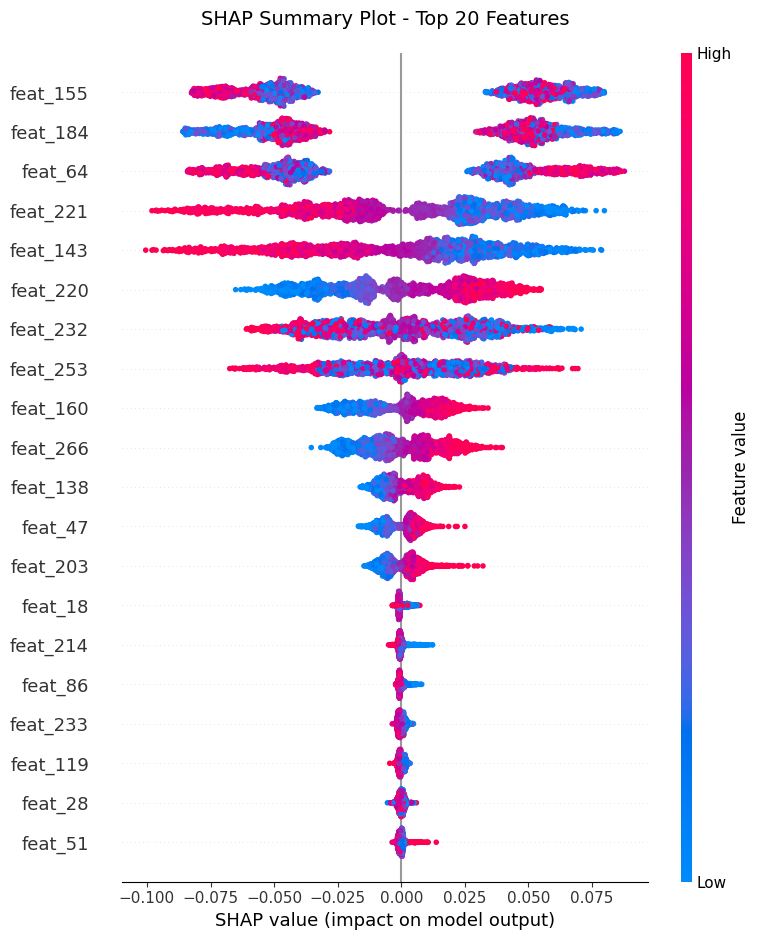


2. SHAP Feature Importance Bar Plot


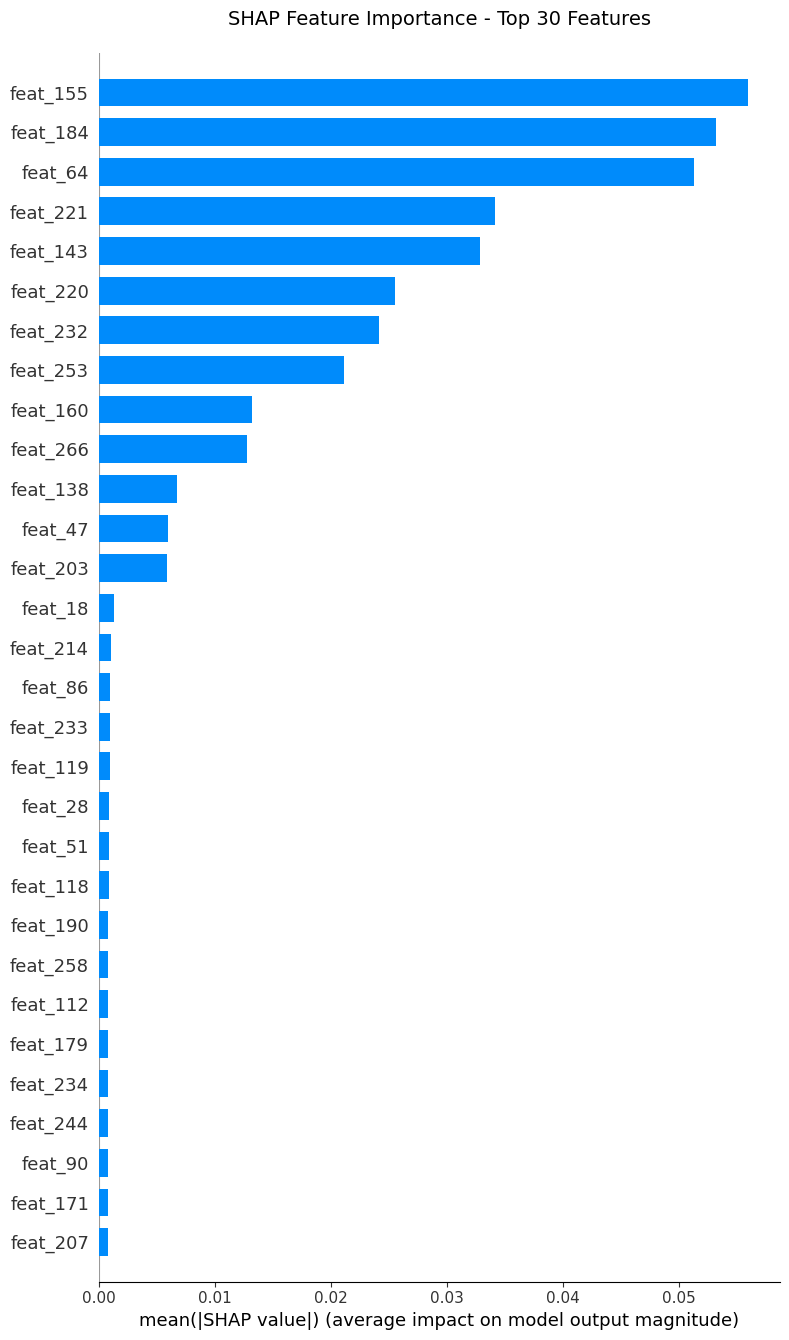


3. All Features Importance Distribution


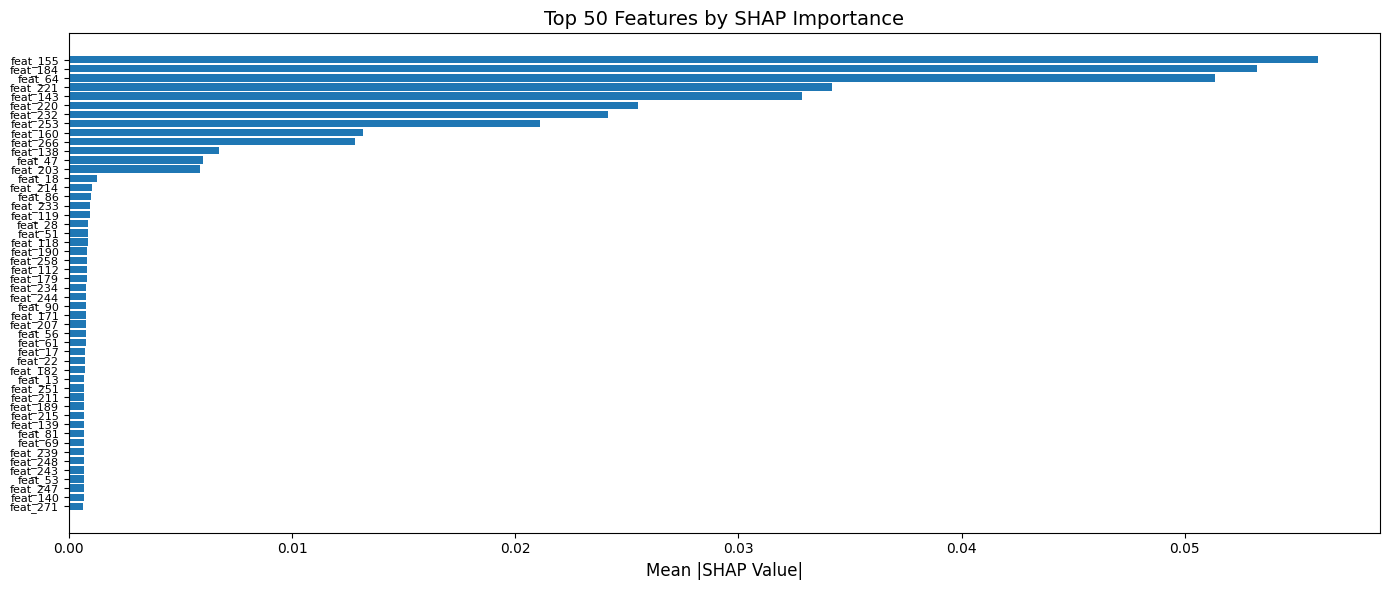


4. Cumulative SHAP Importance


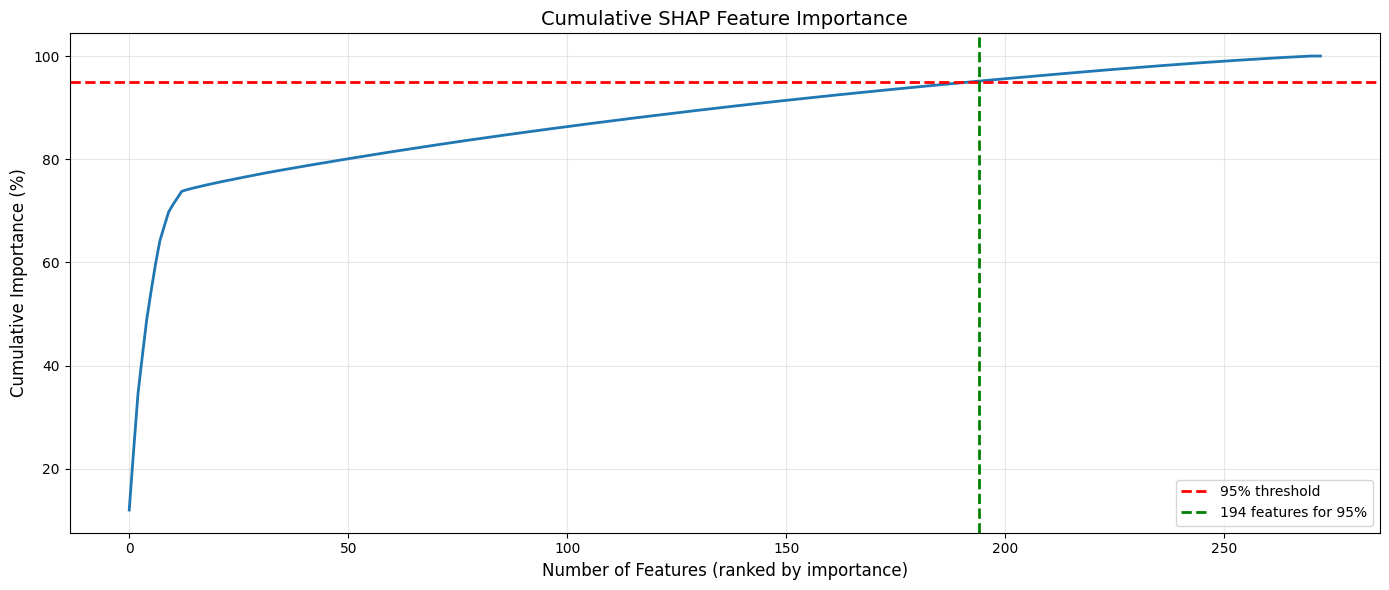


✓ SHAP analysis complete!


In [12]:
# SHAP Visualizations
print("\n" + "="*80)
print("SHAP VISUALIZATIONS")
print("="*80)

# 1. Summary plot - shows impact and distribution
print("\n1. SHAP Summary Plot (Feature Impact Distribution)")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns, show=False, max_display=20)
plt.title('SHAP Summary Plot - Top 20 Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. Bar plot - feature importance ranking
print("\n2. SHAP Feature Importance Bar Plot")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, feature_names=X_train.columns, plot_type="bar", show=False, max_display=30)
plt.title('SHAP Feature Importance - Top 30 Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 3. Custom bar plot for all features (sorted)
print("\n3. All Features Importance Distribution")
fig, ax = plt.subplots(figsize=(14, 6))
top_50 = shap_importance.head(50)
ax.barh(range(len(top_50)), top_50['shap_importance'])
ax.set_yticks(range(len(top_50)))
ax.set_yticklabels(top_50['feature'], fontsize=8)
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Top 50 Features by SHAP Importance', fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# 4. Cumulative importance plot
print("\n4. Cumulative SHAP Importance")
fig, ax = plt.subplots(figsize=(14, 6))
cumulative = (shap_importance['shap_importance'].cumsum() / shap_importance['shap_importance'].sum()) * 100
ax.plot(range(len(cumulative)), cumulative.values, linewidth=2)
ax.axhline(y=95, color='red', linestyle='--', linewidth=2, label='95% threshold')
ax.axvline(x=n_features_95, color='green', linestyle='--', linewidth=2, label=f'{n_features_95} features for 95%')
ax.set_xlabel('Number of Features (ranked by importance)', fontsize=12)
ax.set_ylabel('Cumulative Importance (%)', fontsize=12)
ax.set_title('Cumulative SHAP Feature Importance', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ SHAP analysis complete!")

In [ ]:
# Feature Selection Recommendation based on SHAP
print("="*80)
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*80)

# Strategy 1: Keep top N features
top_100 = shap_importance.head(100)['feature'].tolist()
top_150 = shap_importance.head(150)['feature'].tolist()
top_200 = shap_importance.head(200)['feature'].tolist()

# Strategy 2: Keep features for 95% cumulative importance
features_95 = shap_importance.head(n_features_95)['feature'].tolist()

# Strategy 3: Remove near-zero importance
if len(near_zero_features) > 0:
    features_nonzero = shap_importance[shap_importance['shap_importance'] >= near_zero_threshold]['feature'].tolist()
else:
    features_nonzero = X_train.columns.tolist()

print(f"\n📊 Feature Selection Options:")
print(f"\n1. Keep top 100 features")
print(f"   → Reduces from {len(X_train.columns)} to 100 features ({100/len(X_train.columns)*100:.1f}% retained)")
print(f"   → Covers {(shap_importance.head(100)['shap_importance'].sum() / shap_importance['shap_importance'].sum() * 100):.2f}% of total importance")

print(f"\n2. Keep top 150 features")
print(f"   → Reduces from {len(X_train.columns)} to 150 features ({150/len(X_train.columns)*100:.1f}% retained)")
print(f"   → Covers {(shap_importance.head(150)['shap_importance'].sum() / shap_importance['shap_importance'].sum() * 100):.2f}% of total importance")

print(f"\n3. Keep features for 95% cumulative importance")
print(f"   → Reduces from {len(X_train.columns)} to {n_features_95} features ({n_features_95/len(X_train.columns)*100:.1f}% retained)")
print(f"   → By definition covers 95% of total importance")

if len(near_zero_features) > 0:
    print(f"\n4. Remove near-zero importance features (< {near_zero_threshold})")
    print(f"   → Reduces from {len(X_train.columns)} to {len(features_nonzero)} features ({len(features_nonzero)/len(X_train.columns)*100:.1f}% retained)")
    print(f"   → Removes {len(near_zero_features)} truly uninformative features")

print(f"\n💡 RECOMMENDATION:")
print(f"   After seeing results with all features, try Option 3 (95% cumulative)")
print(f"   This balances dimensionality reduction with information retention")
print(f"   Expected outcome: Similar or better validation score with {len(X_train.columns) - n_features_95} fewer features")

## SHAP Analysis - Feature Importance & Interpretability

**What we're checking:**
- Which features truly contribute to predictions
- Feature importance using game-theoretic approach
- Identify features that can be safely removed
- Understand model behavior

**Why SHAP is better than default importance:**
- Fair attribution based on Shapley values
- Accounts for feature interactions

## Comparison with Other Models

**GridSearchCV (LightGBM):**
- CV RMSE: 0.1008
- Train RMSE: 0.0259, Train R²: 0.9871
- Val RMSE: 0.0877, Val R²: 0.8535
- RMSE Gap: 0.0617 ⚠️
- R² Gap: 0.1336 ⚠️

**Optuna + LightGBM:**
- With regularization and 150 trials
- Expected smaller overfitting gap

**Optuna + CatBoost (Current):**
- Expected benefits from symmetric trees
- Ordered boosting reduces overfitting
- See results above

In [ ]:
# Train final model with best hyperparameters
print("\n" + "="*80)
print("Training Final Model with Best Hyperparameters")
print("="*80)

best_params = best_trial.params
best_model = CatBoostRegressor(**best_params, verbose=0)

# Train on training set
best_model.fit(X_train_processed, y_train)

# Evaluate on both train and validation
y_train_pred = best_model.predict(X_train_processed)
y_val_pred = best_model.predict(X_val_processed)

train_rmse_final = rmse(y_train, y_train_pred)
val_rmse_final = rmse(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"\nFinal Model Performance:")
print(f"{'Metric':<20} {'Train':<15} {'Validation':<15}")
print("="*50)
print(f"{'RMSE':<20} {train_rmse_final:<15.4f} {val_rmse_final:<15.4f}")
print(f"{'R²':<20} {train_r2:<15.4f} {val_r2:<15.4f}")
print(f"{'Overfitting Gap':<20} {val_rmse_final - train_rmse_final:<15.4f}")

In [ ]:
# Retrain on FULL dataset for final predictions
print("\n" + "="*80)
print("Retraining on Full Dataset for Final Predictions")
print("="*80)

# Preprocess full data
X_full_processed = preprocess.fit_transform(X)
X_eval_processed = preprocess.transform(X_eval)

# Train on all data
final_model = CatBoostRegressor(**best_params, verbose=0)
final_model.fit(X_full_processed, y1)

# Generate predictions
eval_pred = final_model.predict(X_eval_processed)

# Calculate in-sample metrics (for reference only)
y_full_pred = final_model.predict(X_full_processed)
full_rmse = rmse(y1, y_full_pred)
full_r2 = r2_score(y1, y_full_pred)

print(f"\nFull Data Training Metrics (in-sample):")
print(f"RMSE: {full_rmse:.4f}")
print(f"R²: {full_r2:.4f}")

# Save predictions
output_filename = f"EVAL_target01_{PROBLEM_NUM}_catboost.csv"
submission = pd.DataFrame({"target01": eval_pred})
submission.to_csv(output_filename, index=False)

print(f"\nSaved: {output_filename}")
print(f"Predictions shape: {eval_pred.shape}")
print(f"Predictions range: [{eval_pred.min():.4f}, {eval_pred.max():.4f}]")

print("\n" + "="*80)
print("Expected Test RMSE: ~{:.4f} (based on validation)".format(val_rmse_final))
print("="*80)

In [ ]:
# Visualize optimization history
try:
    fig1 = plot_optimization_history(study)
    fig1.show()
    
    fig2 = plot_param_importances(study)
    fig2.show()
    
    print("Visualization plots displayed above.")
except Exception as e:
    print(f"Visualization requires plotly. Install with: pip install plotly")
    print(f"Error: {e}")

## CatBoost vs LightGBM Key Differences

**CatBoost Advantages:**
1. **Ordered Boosting:** Reduces prediction shift and overfitting
2. **Symmetric Trees:** Better generalization, less prone to overfitting
3. **Built-in Regularization:** Strong default regularization parameters
4. **Random Strength:** Adds randomness to split selection
5. **Bagging Temperature:** Controls Bayesian bootstrap aggressiveness

**LightGBM Advantages:**
1. **Faster Training:** Especially on large datasets
2. **More Flexible:** More hyperparameters to tune
3. **Lower Memory:** Better for very large datasets

**Regularization Comparison:**
- LightGBM: `reg_alpha` (L1), `reg_lambda` (L2)
- CatBoost: `l2_leaf_reg`, `random_strength`, `bagging_temperature`

Both models should achieve similar performance with proper tuning!